# Introduction

# Data

# Background

# Investigations

In [86]:
#Setup

import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import chisquare
from scipy.stats import chi2
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
import warnings
warnings.filterwarnings("ignore")


In [87]:
#Functions


#Returns a dataframe
#groups by season so 12 is winter 3 is spring 6 is summer 9 is autumn

def get_season_nogroup(df):
    temp = df.groupby(pd.Grouper(key = 'Date', freq = 'BQS-MAR')).mean().reset_index()
    temp['Season'] = pd.DatetimeIndex(temp['Date']).month
    return temp


#Returns a dataframe
#groups by season so 12 is winter 3 is spring 6 is summer 9 is autumn
#and then groups again across all years

def get_season(df):
    temp = df.groupby(pd.Grouper(key = 'Date', freq = 'BQS-MAR')).mean().reset_index()
    temp['Season'] = pd.DatetimeIndex(temp['Date']).month
    temp = temp.groupby('Season').mean().reset_index()
    #temp['Season'].replace(to_replace = {12: 'Winter', 3: 'Spring', 6: 'Summer', 9: 'Autumn'}, inplace=True)
    return temp


#Returns a df
#performs ols trying to predict the y

def get_pi(x, y, a, df):
    mod = sm.OLS(y, x)
    res = mod.fit()
    predictions = res.get_prediction(x)
    pi = predictions.summary_frame(alpha = a)
    pi['Season'] = x
    return pi.iloc[:, np.r_[0:4, -1]]


#Returns an int
#Uses the pca components to do linear regression and returns the RMSE

def lr(X, y, num_components):
    #Time series test train split
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    #Using pca components
    pca = PCA(n_components = num_components)
    X_pca = pca.fit_transform(X_train)
    X_pca_test = pca.fit_transform(X_test)
    lm = LinearRegression()
    model = lm.fit(X_pca, y_train)
    y_pred = model.predict(X_pca_test)
    residuals = y_test - y_pred
    return round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3), residuals, y_pred


#Linear regressino without pca
def lr_nopca(X, y):
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    return round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3), residuals, y_pred


#Can print out two df's next to each other
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

#Gets the parameters
#Returns df

def get_params(X, y, df, date = True, other = None):
    alpha = 0.05
    
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    mod = sm.OLS(y, X)
    res = mod.fit()
    
    if other is not None:
        cols = [i for i in df.columns if i not in other]
    else:
        cols = df.columns
        
    temp = {el:[pa, b, p] for el, pa, b, p in zip(cols, np.round(res.params, 3), 
                                                  np.round(res.bse, 3), np.round(res.pvalues, 3))}
    if date:
        del temp['Date']
    for key in list(temp.keys()):
        if temp[key][2] > alpha:
            del temp[key]
            
    dff = pd.DataFrame.from_dict(temp, orient = 'index', columns = ['Coefficient', 'Standard Error', 'P-Value'])
    dff.index.name = 'Predictor'
    return dff


In [88]:
#Reading data

spring_amiata = pd.read_csv('acea-water-prediction/Water_Spring_Amiata.csv')
spring_lupa = pd.read_csv('acea-water-prediction/Water_Spring_Lupa.csv')
spring_madonna = pd.read_csv('acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv')
river = pd.read_csv('acea-water-prediction/River_Arno.csv')
lake = pd.read_csv('acea-water-prediction/Lake_Bilancino.csv')


## Aquifers

In [89]:
df = pd.read_excel('acea-water-prediction/datasets_description.xlsx')
data = df['Database']
filenames = []
for i in data:
    i = i.strip()
    filenames.append( 'acea-water-prediction/' + str(i)+'.csv')

In [90]:
def load_files(filenames):
    for filename in filenames:
        yield pd.read_csv(filename)

dfs = list(load_files(filenames))

Auser_aquifer = dfs[0]
Auser_aquifer = Auser_aquifer.assign(**{'Date' : pd.to_datetime(Auser_aquifer.Date)})
Auser_aquifer = Auser_aquifer.set_index('Date')

# Amiata_aquifer = dfs[1]
# Amiata_aquifer = Amiata_aquifer.assign(**{'Date' : pd.to_datetime(Amiata_aquifer.Date)})
# Amiata_aquifer = Amiata_aquifer.set_index('Date')

Petrignano_aquifer = dfs[2]
Petrignano_aquifer = Petrignano_aquifer.assign(**{'Date' : pd.to_datetime(Petrignano_aquifer.Date)})
Petrignano_aquifer = Petrignano_aquifer.set_index('Date')

Doganella_aquifer = dfs[3]
Doganella_aquifer = Doganella_aquifer.assign(**{'Date' : pd.to_datetime(Doganella_aquifer.Date)})
Doganella_aquifer = Doganella_aquifer.set_index('Date')

Luco_aquifer = dfs[4]
Luco_aquifer = Luco_aquifer.assign(**{'Date' : pd.to_datetime(Luco_aquifer.Date)})
Luco_aquifer = Luco_aquifer.set_index('Date')

aqs = [Auser_aquifer, Petrignano_aquifer, Doganella_aquifer, Luco_aquifer]
aqns = ['Auser_aquifer', 'Petrignano_aquifer', 'Doganella_aquifer', 'Luco_aquifer']

# fig, ax = plt.subplots(nrows = len(aqs), figsize=(100, 120))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# a = 0
# heatmapd = []
# for aq in aqs:
#     au = ax[a]
#     corr = aq.corr()
#     mask = np.triu(np.ones_like(corr, dtype=bool))
#     heatmapd.append(sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = au))
#     a += 1

#THESE HEATMAPS LOOK DISGUSTING

### Auser

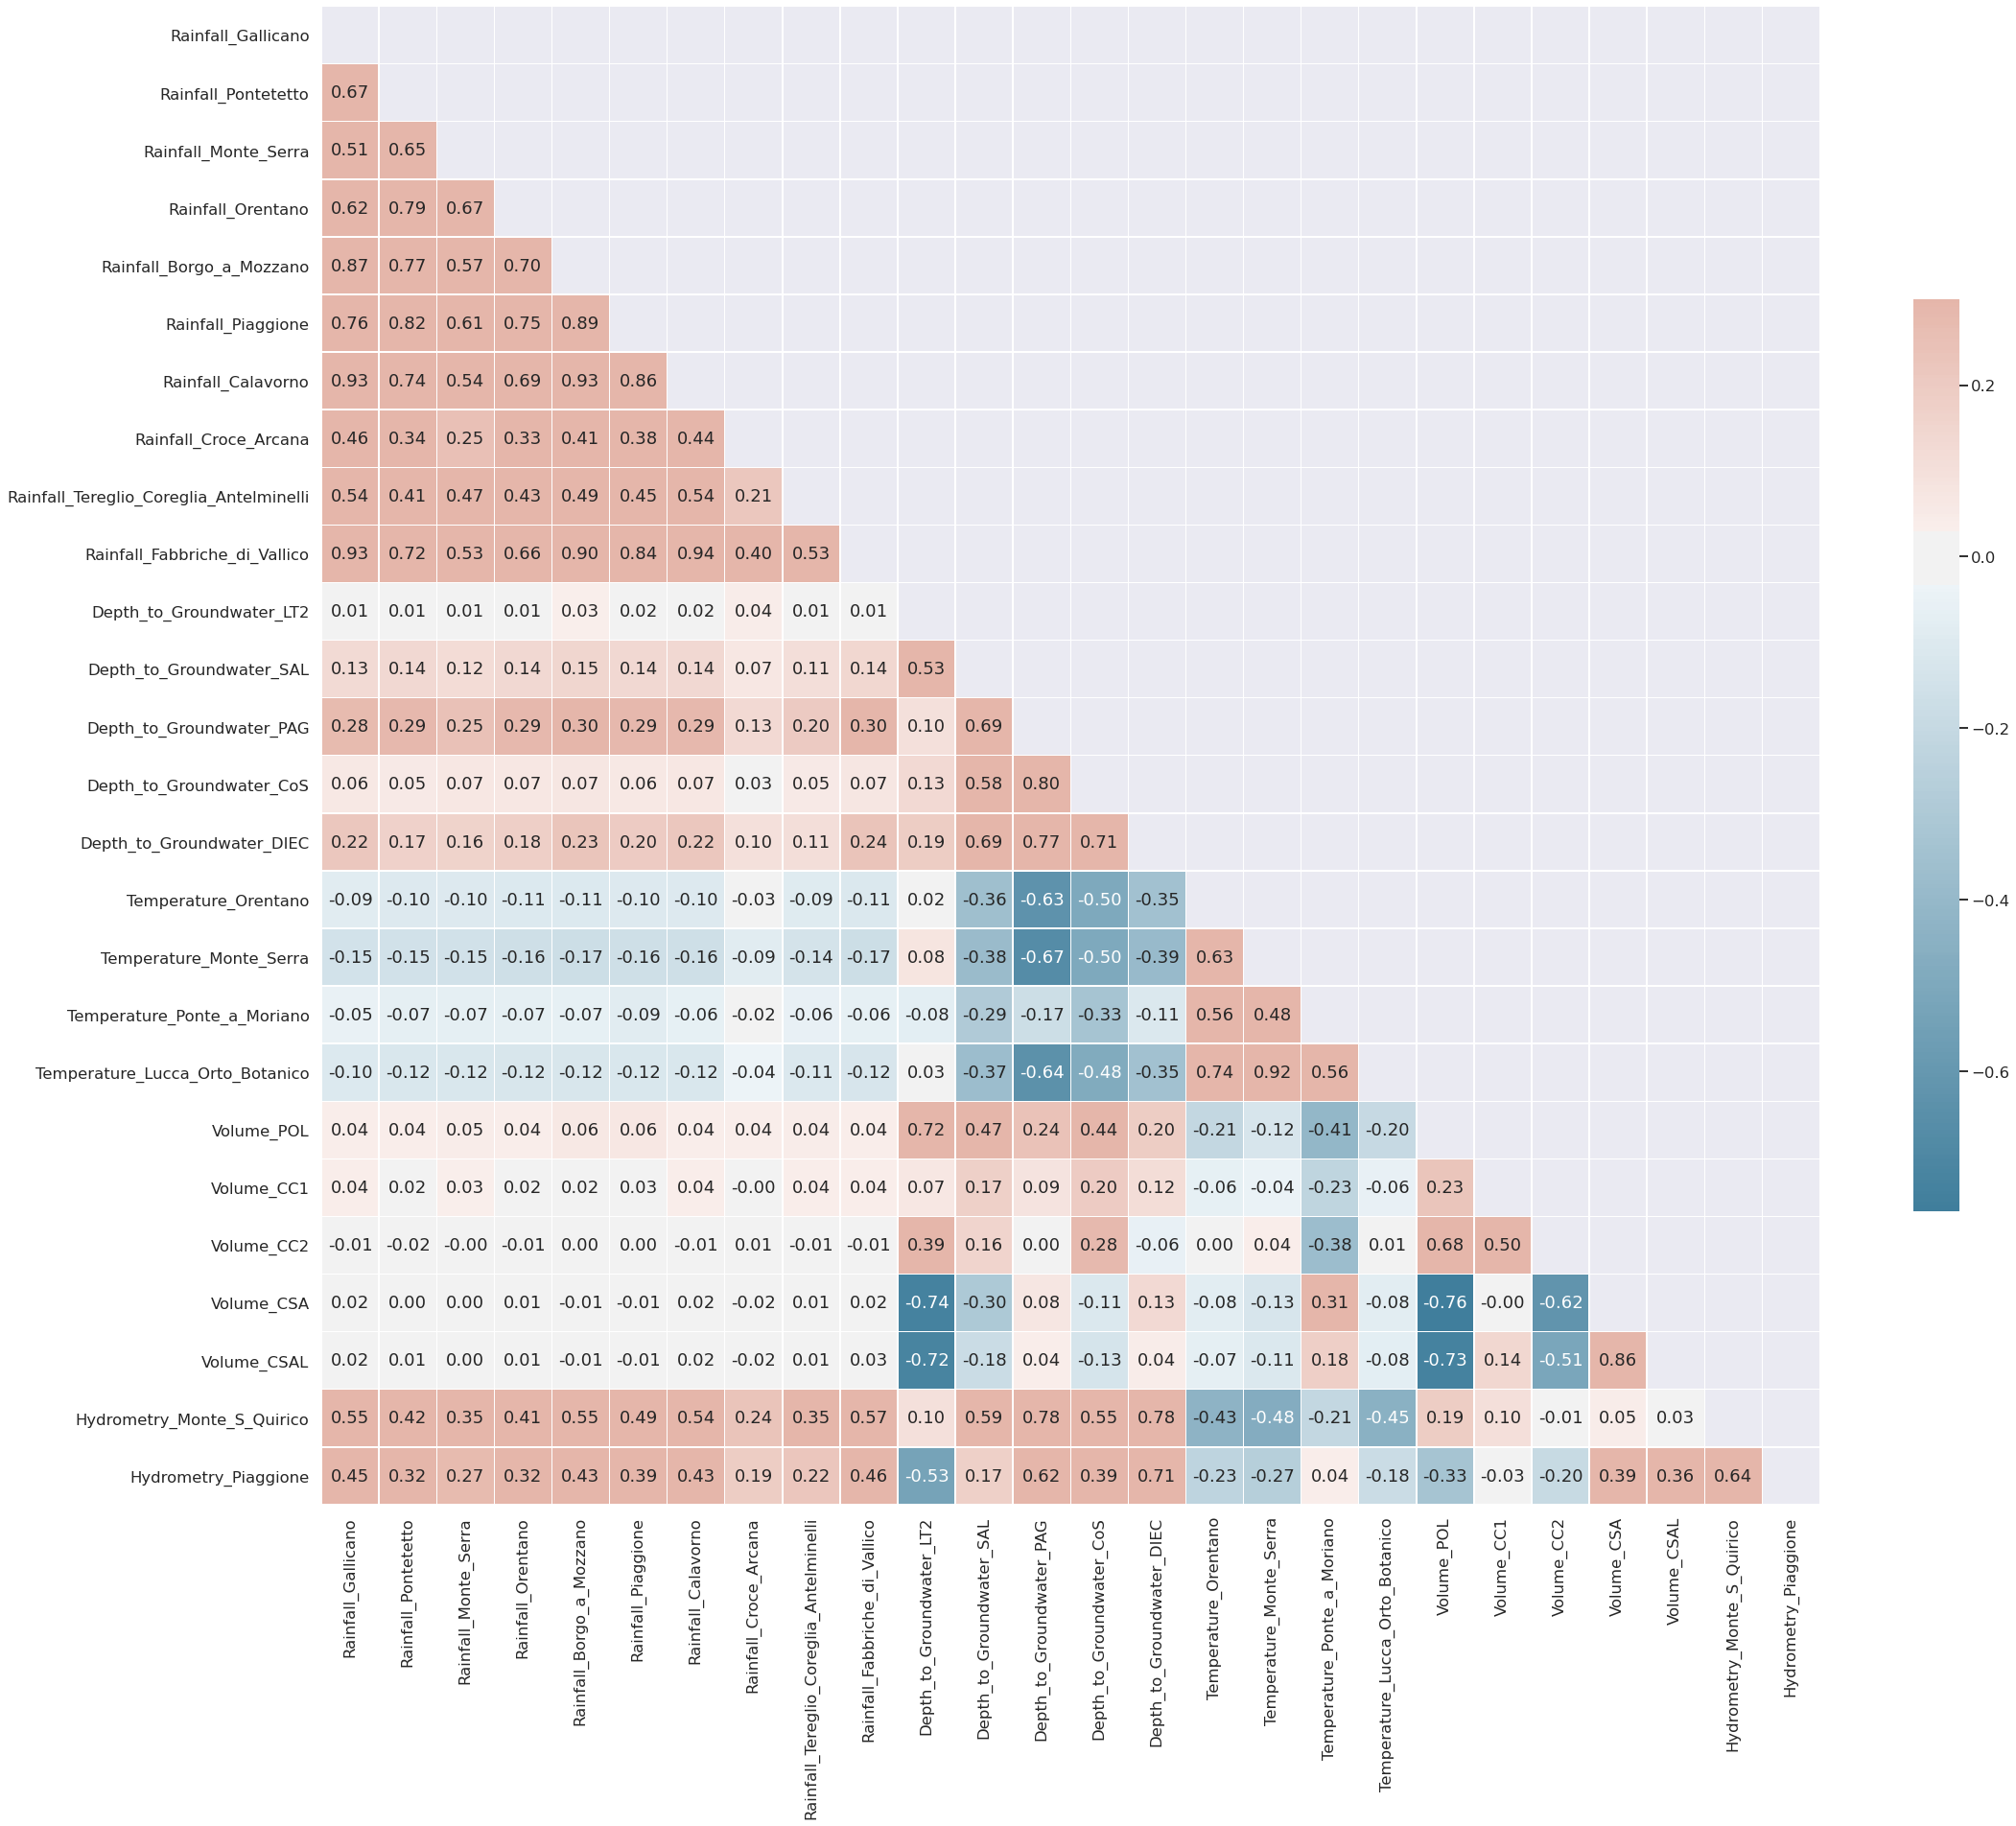

In [91]:
fig, ax = plt.subplots(figsize=(35, 35))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
au = 'Auser_aquifer'
corr = Auser_aquifer.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = ax)
plt.show()

As you can see from the heatmap above, many of the rainfalls are correlated across regions, which makes sense as they are likely close to each other. Additionally, it seems like the depth to groundwater (outcome) measures are not well correlated with other features other than the other depths to groundwater.

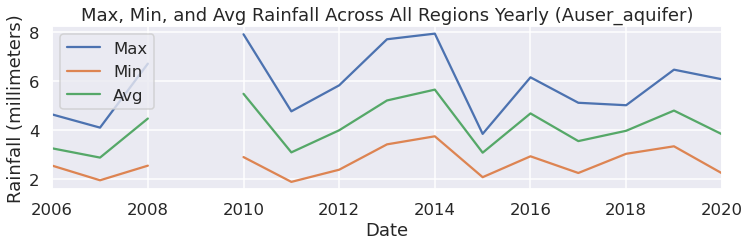

In [92]:
i = Auser_aquifer
au = 'Auser_aquifer'
rainy_cols = i.iloc[:, i.columns.str.contains('Rain')].reset_index()
temp = rainy_cols.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index()
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:, :11].max(axis = 1)
temp['min'] = temp.iloc[:, :11].min(axis = 1)
temp['avg'] = temp.iloc[:, :11].mean(axis = 1)
fig, ax = plt.subplots(figsize=(12, 3))
temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, and Avg Rainfall Across All Regions Yearly (' + au + ')')
ax.set_ylabel('Rainfall (millimeters)')
plt.show()

As you can see above, the Auser aquifer has a wide variety of rainfall meaures, with some years receiving as much as 5 mm on average and other years staying much drier with half the volume of rainfall. This graph gives a good idea of how the rainfall changes from year to year. Additionally, we see that there was no data collected in the year 2009. 

In [93]:
temp = aqs[0].reset_index()
temp = temp[list(aqs[0].reset_index().columns[np.r_[0:11, 16:27, 11:16]])]

a_pi = pd.DataFrame(index = temp.columns[1:22], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
a_pi.index.name = 'Region'

for i in range(1, 22):
    temp2 = temp.dropna(subset = [temp.columns[i]])
    temp2 = get_season_nogroup(temp2).dropna(subset = [temp.columns[i]])
    x = temp2['Season']
    y = temp2.iloc[:, i]
    tempp = get_pi(x, y, 0.05, temp2)
    tempp = tempp.groupby('Season').mean().reset_index()
    a_pi.iloc[i - 1,:] = round(tempp.iloc[:,3:5], 3).values.tolist()
    
cols = list(a_pi.columns)
cols = [cols[-1]] + cols[:-1]
a_pi = a_pi[cols]
a_pi

,Winter,Spring,Summer,Autumn
Region,,,,
Rainfall_Gallicano,"[6.003, 7.76]","[1.501, 1.94]","[3.002, 3.88]","[4.502, 5.82]"
Rainfall_Pontetetto,"[4.248, 5.505]","[1.062, 1.376]","[2.124, 2.753]","[3.186, 4.129]"
Rainfall_Monte_Serra,"[4.797, 6.269]","[1.199, 1.567]","[2.399, 3.134]","[3.598, 4.702]"
Rainfall_Orentano,"[3.767, 4.943]","[0.942, 1.236]","[1.884, 2.472]","[2.826, 3.707]"
Rainfall_Borgo_a_Mozzano,"[5.689, 7.314]","[1.422, 1.828]","[2.845, 3.657]","[4.267, 5.485]"
Rainfall_Piaggione,"[4.835, 6.243]","[1.209, 1.561]","[2.418, 3.121]","[3.626, 4.682]"
Rainfall_Calavorno,"[5.539, 7.169]","[1.385, 1.792]","[2.769, 3.585]","[4.154, 5.377]"
Rainfall_Croce_Arcana,"[2.918, 4.192]","[0.729, 1.048]","[1.459, 2.096]","[2.188, 3.144]"
Rainfall_Tereglio_Coreglia_Antelminelli,"[4.983, 6.517]","[1.246, 1.629]","[2.491, 3.258]","[3.737, 4.888]"


Above, we see the generated prediction intervals of the estimated seasonal rainfall, temperature, volume, and hydrometry. Using these prediction intervals along with the correlations and regression coefficients will allow us to determine what affects the depth to groundwater the most and what season will be optimal for water extraction. 

In [94]:
a_pi.to_csv('aquifer1.csv')

In [95]:
df = Auser_aquifer
df = df.dropna()
aqui = 'Auser_aquifer'
print('Linear regression PCA models for ' + aqui)
endog = df.columns[df.columns.str.contains('Depth')]
Y = df[endog]
exog = df.columns.difference(Y.columns)
X = df[exog].values
obs = []
for col in Y.columns:
    ytemp = Y[col].values
    components = len(exog) // 2
    rmse, residuals, pred =  lr(X, ytemp, components)
    obs.append(get_params(X, ytemp, df, False, endog))
    print("     RMSE when predicting the "+ str(col), rmse)

Linear regression PCA models for Auser_aquifer
     RMSE when predicting the Depth_to_Groundwater_LT2 1.144
     RMSE when predicting the Depth_to_Groundwater_SAL 1.131
     RMSE when predicting the Depth_to_Groundwater_PAG 0.805
     RMSE when predicting the Depth_to_Groundwater_CoS 2.074
     RMSE when predicting the Depth_to_Groundwater_DIEC 0.777


As you can see above, there isa bit of error on linear regression predcitions of all depths, but CoS is significantly worse (about 2x as much error) than any of the other presented linear regression models. 

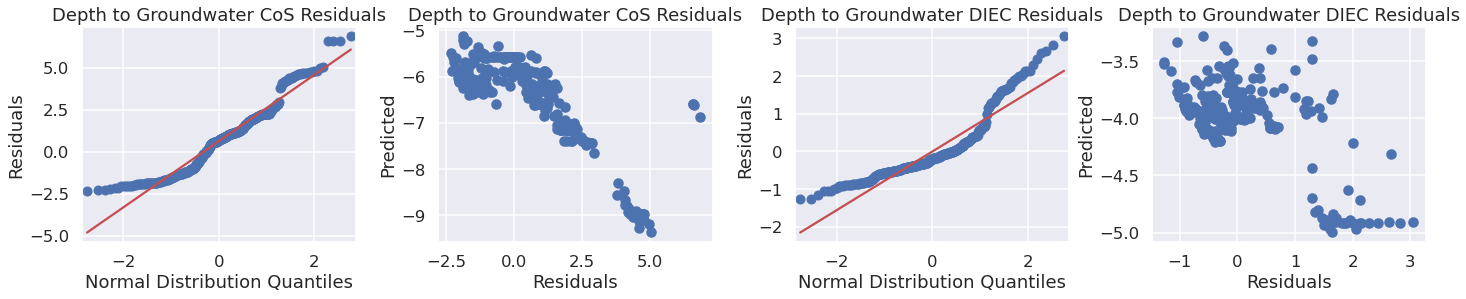

In [96]:
rmse, res1, pred1 =  lr(X, Y[Y.columns[-2]].values, components)
rmse, res2, pred2 =  lr(X, Y[Y.columns[-1]].values, components)

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)

sm.qqplot(res1, line='s', ax = ax[0])
ax[0].set_title('Depth to Groundwater CoS Residuals')
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res2, line='s', ax = ax[2])
ax[2].set_title('Depth to Groundwater DIEC Residuals')
ax[2].set_ylabel('Residuals')
ax[2].set_xlabel('Normal Distribution Quantiles')

ax[1].scatter(res1, pred1)
ax[1].set_title('Depth to Groundwater CoS Residuals')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Predicted')

ax[3].scatter(res2, pred2)
ax[3].set_title('Depth to Groundwater DIEC Residuals')
ax[3].set_xlabel('Residuals')
ax[3].set_ylabel('Predicted')


plt.show()

Above, we see two of the five residual plots. In both cases, we see that the distribution of the residuals does not follow a normal distribution. The Cos residuals scatter plots shows a negative sloped scatter plot while the DIEC residuals scatter plots dot not should much of an obvious patter and is somewhat centered around 0. 

In [97]:
print('Predicting Depth to Groundwater CoS (Left) and DIEC (Right)')
multi_table([obs[-2], obs[-1]])

Predicting Depth to Groundwater CoS (Left) and DIEC (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Gallicano,3.046,0.202,0.000
Rainfall_Monte_Serra,-0.011,0.005,0.042
Rainfall_Orentano,0.021,0.005,0.000
Rainfall_Piaggione,-0.010,0.004,0.016
Rainfall_Calavorno,-0.012,0.004,0.002
Rainfall_Croce_Arcana,-0.006,0.003,0.016
Temperature_Ponte_a_Moriano,0.245,0.030,0.000
Temperature_Lucca_Orto_Botanico,-0.041,0.009,0.000
Volume_POL,-0.233,0.031,0.000


As you can see from the tables above, most of the features in the dataset are not strongly correlated with the varied depth outcomes. Above, we displayed two out of the five coefficients as they were relatively similar. In fact, even the other depths are not strongly correlated with the depth outcomes, and many are not statistically significant. The two constant and strong correlated throughout all five regression models was the rainfall in the regions of Gallicano and Pontetto. This was not too surprising as the these two were constantly held the highest Pearson correlation coefficient with the depth to ground water variables. 

In [98]:
obs[-2].to_csv('aquifer1-1.csv')
obs[-1].to_csv('aquifer1-2.csv')

### Petrignano

In [99]:
aqs[1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5223 entries, 2006-03-14 to 2020-06-30
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Rainfall_Bastia_Umbra                 4199 non-null   float64
 1   Depth_to_Groundwater_P24              5168 non-null   float64
 2   Depth_to_Groundwater_P25              5184 non-null   float64
 3   Temperature_Bastia_Umbra              4199 non-null   float64
 4   Temperature_Petrignano                4199 non-null   float64
 5   Volume_C10_Petrignano                 5025 non-null   float64
 6   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7)
memory usage: 326.4 KB


Above we see that this is one of the few complete datasets that we are given. For the predictor variables we have between 4000-5000 observations and for the outcome variables we have around 5000 observations. Hence, we do not need to drop any big pieces of data. 

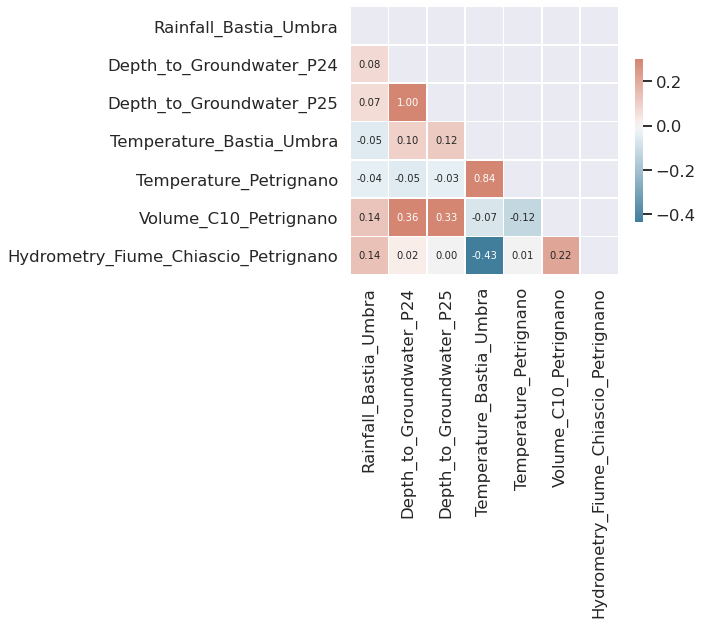

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
au = 'Petrignano_aquifer'
corr = Petrignano_aquifer.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = ax, annot_kws={"size": 10})
plt.show()

As you can see from the heatmap above, many of the rainfalls are correlated across regions, which makes sense as they are likely close to each other. Additionally, it seems like the depth to groundwater (outcome) measures are not well correlated with other features other than the other depths to groundwater.

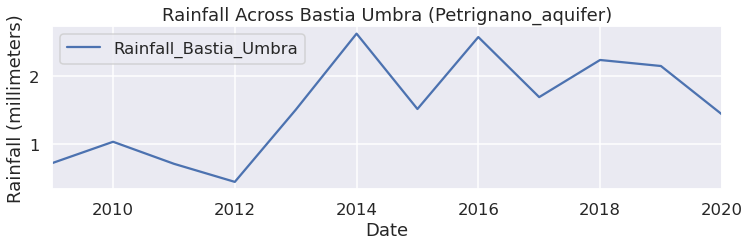

In [101]:
i = Petrignano_aquifer
au = 'Petrignano_aquifer'
rainy_cols = i.iloc[:, i.columns.str.contains('Rain')].reset_index()
temp = rainy_cols.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index()
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
fig, ax = plt.subplots(figsize=(12, 3))
temp.plot(kind = 'line', x = 'Date', y = 'Rainfall_Bastia_Umbra', ax = ax)
ax.set_title('Rainfall Across Bastia Umbra (' + au + ')')
ax.set_ylabel('Rainfall (millimeters)')
plt.show()

As you can see above, the petrignano aquifer has a less variety of rainfall meaures than most of the other aquifers, with values between .5mm and 2.5 mm. This graph gives a good idea of how the rainfall changes from year to year, and seems relatively consistent with the Auser number as 2014 is a relatively wet year in these regions as well.

In [102]:
temp = aqs[1].reset_index()
temp = temp[list(aqs[1].reset_index().columns[np.r_[0:2, 4:8, 2:4]])]

a_pi = pd.DataFrame(index = temp.columns[1:6], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
a_pi.index.name = 'Region'

for i in range(1, 6):
    temp2 = temp.dropna(subset = [temp.columns[i]])
    temp2 = get_season_nogroup(temp2).dropna(subset = [temp.columns[i]])
    x = temp2['Season']
    y = temp2.iloc[:, i]
    tempp = get_pi(x, y, 0.05, temp2)
    tempp = tempp.groupby('Season').mean().reset_index()
    a_pi.iloc[i - 1,:] = round(tempp.iloc[:,3:5], 3).values.tolist()
    
cols = list(a_pi.columns)
cols = [cols[-1]] + cols[:-1]
a_pi = a_pi[cols]
a_pi

,Winter,Spring,Summer,Autumn
Region,,,,
Rainfall_Bastia_Umbra,"[1.476, 2.403]","[0.369, 0.601]","[0.738, 1.202]","[1.107, 1.802]"
Temperature_Bastia_Umbra,"[14.467, 21.935]","[3.617, 5.484]","[7.234, 10.967]","[10.851, 16.451]"
Temperature_Petrignano,"[13.314, 20.347]","[3.328, 5.087]","[6.657, 10.174]","[9.985, 15.26]"
Volume_C10_Petrignano,"[-43118.272, -34054.395]","[-10779.568, -8513.599]","[-21559.136, -17027.197]","[-32338.704, -25540.796]"
Hydrometry_Fiume_Chiascio_Petrignano,"[2.764, 3.589]","[0.691, 0.897]","[1.382, 1.795]","[2.073, 2.692]"


Above is the prediction intervals for the Petrignano aquifer. We see that in the Summer and Autumn months, the rainfall is fairly constant while in the Winter is could be double.  

In [103]:
a_pi.to_csv('aquifer2.csv')

In [104]:
df = Petrignano_aquifer
df = df.dropna()
aqui = 'Petrignano_aquifer'
print('Linear regression PCA models for ' + aqui)
endog = df.columns[df.columns.str.contains('Depth')]
Y = df[endog]
exog = df.columns.difference(Y.columns)
X = df[exog].values
obs = []
for col in Y.columns:
    ytemp = Y[col].values
    components = len(exog) // 2
    rmse, residuals, pred =  lr(X, ytemp, components)
    obs.append(get_params(X, ytemp, df, False, endog))
    print("     RMSE when predicting the "+ str(col), rmse)

Linear regression PCA models for Petrignano_aquifer
     RMSE when predicting the Depth_to_Groundwater_P24 2.339
     RMSE when predicting the Depth_to_Groundwater_P25 2.234


As you can see above, the RMSE for these models is uniformly higher than the presented models for the Auser aquifer.

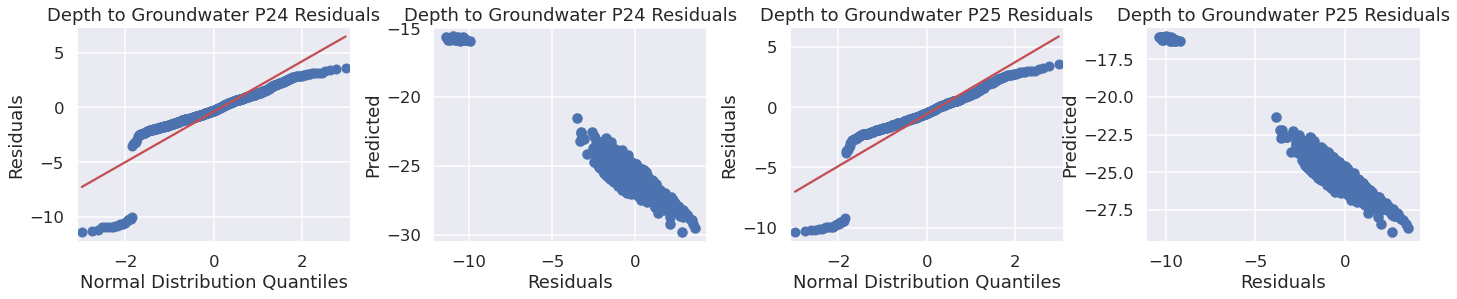

In [105]:
rmse, res1, pred1 =  lr(X, Y[Y.columns[0]].values, components)
rmse, res2, pred2 =  lr(X, Y[Y.columns[1]].values, components)

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)

sm.qqplot(res1, line='s', ax = ax[0])
ax[0].set_title('Depth to Groundwater P24 Residuals')
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res2, line='s', ax = ax[2])
ax[2].set_title('Depth to Groundwater P25 Residuals')
ax[2].set_ylabel('Residuals')
ax[2].set_xlabel('Normal Distribution Quantiles')

ax[1].scatter(res1, pred1)
ax[1].set_title('Depth to Groundwater P24 Residuals')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Predicted')

ax[3].scatter(res2, pred2)
ax[3].set_title('Depth to Groundwater P25 Residuals')
ax[3].set_xlabel('Residuals')
ax[3].set_ylabel('Predicted')


plt.show()

Once again, we see that the residuals are not normally distributed and not randomly scatted. This leads us to believe that a linear model is not suitable for our data. 

In [106]:
print('Predicting Depth to Groundwater at P24 (Left), at P25 (Right)')
multi_table(obs)

Predicting Depth to Groundwater at P24 (Left), at P25 (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Bastia_Umbra,-3.395,0.081,0.0
Temperature_Petrignano,-0.258,0.014,0.0
Volume_C10_Petrignano,0.206,0.014,0.0
Hydrometry_Fiume_Chiascio_Petrignano,0.001,0.000,0.0
,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Bastia_Umbra,-3.504,0.080,0.0
Temperature_Petrignano,-0.266,0.014,0.0
Volume_C10_Petrignano,0.218,0.014,0.0


The Petrignano aquifer only has 2 depth measures, both of which have strong negative correlation with rainfall in Bastia Umbra and a small amount of negative correlation with the temperature in the Petrignano region. Further, there is a small amount of spositive correlation with the Volume c10 Petrignano. As you can see, there is little correlation with any of the other features present in the dataset. 

In [107]:
obs[0].to_csv('aquifer2-1.csv')
obs[1].to_csv('aquifer2-2.csv')

### Doganella

In [108]:
aqs[2].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6026 entries, 2004-01-01 to 2020-06-30
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rainfall_Monteporzio          5399 non-null   float64
 1   Rainfall_Velletri             5374 non-null   float64
 2   Depth_to_Groundwater_Pozzo_1  2537 non-null   float64
 3   Depth_to_Groundwater_Pozzo_2  2736 non-null   float64
 4   Depth_to_Groundwater_Pozzo_3  2774 non-null   float64
 5   Depth_to_Groundwater_Pozzo_4  2374 non-null   float64
 6   Depth_to_Groundwater_Pozzo_5  2508 non-null   float64
 7   Depth_to_Groundwater_Pozzo_6  2428 non-null   float64
 8   Depth_to_Groundwater_Pozzo_7  2311 non-null   float64
 9   Depth_to_Groundwater_Pozzo_8  2551 non-null   float64
 10  Depth_to_Groundwater_Pozzo_9  2339 non-null   float64
 11  Volume_Pozzo_1                1356 non-null   float64
 12  Volume_Pozzo_2                1360 non-null 

In the above output, we see the Doganella aquifer dataset. This dataset is particularly large with 9 outcome variables and 12 predictor variables. Because the number of valid data is fairly similar throughout the dataset, around 1000-2000, we do not need to drop any variable entirely. 

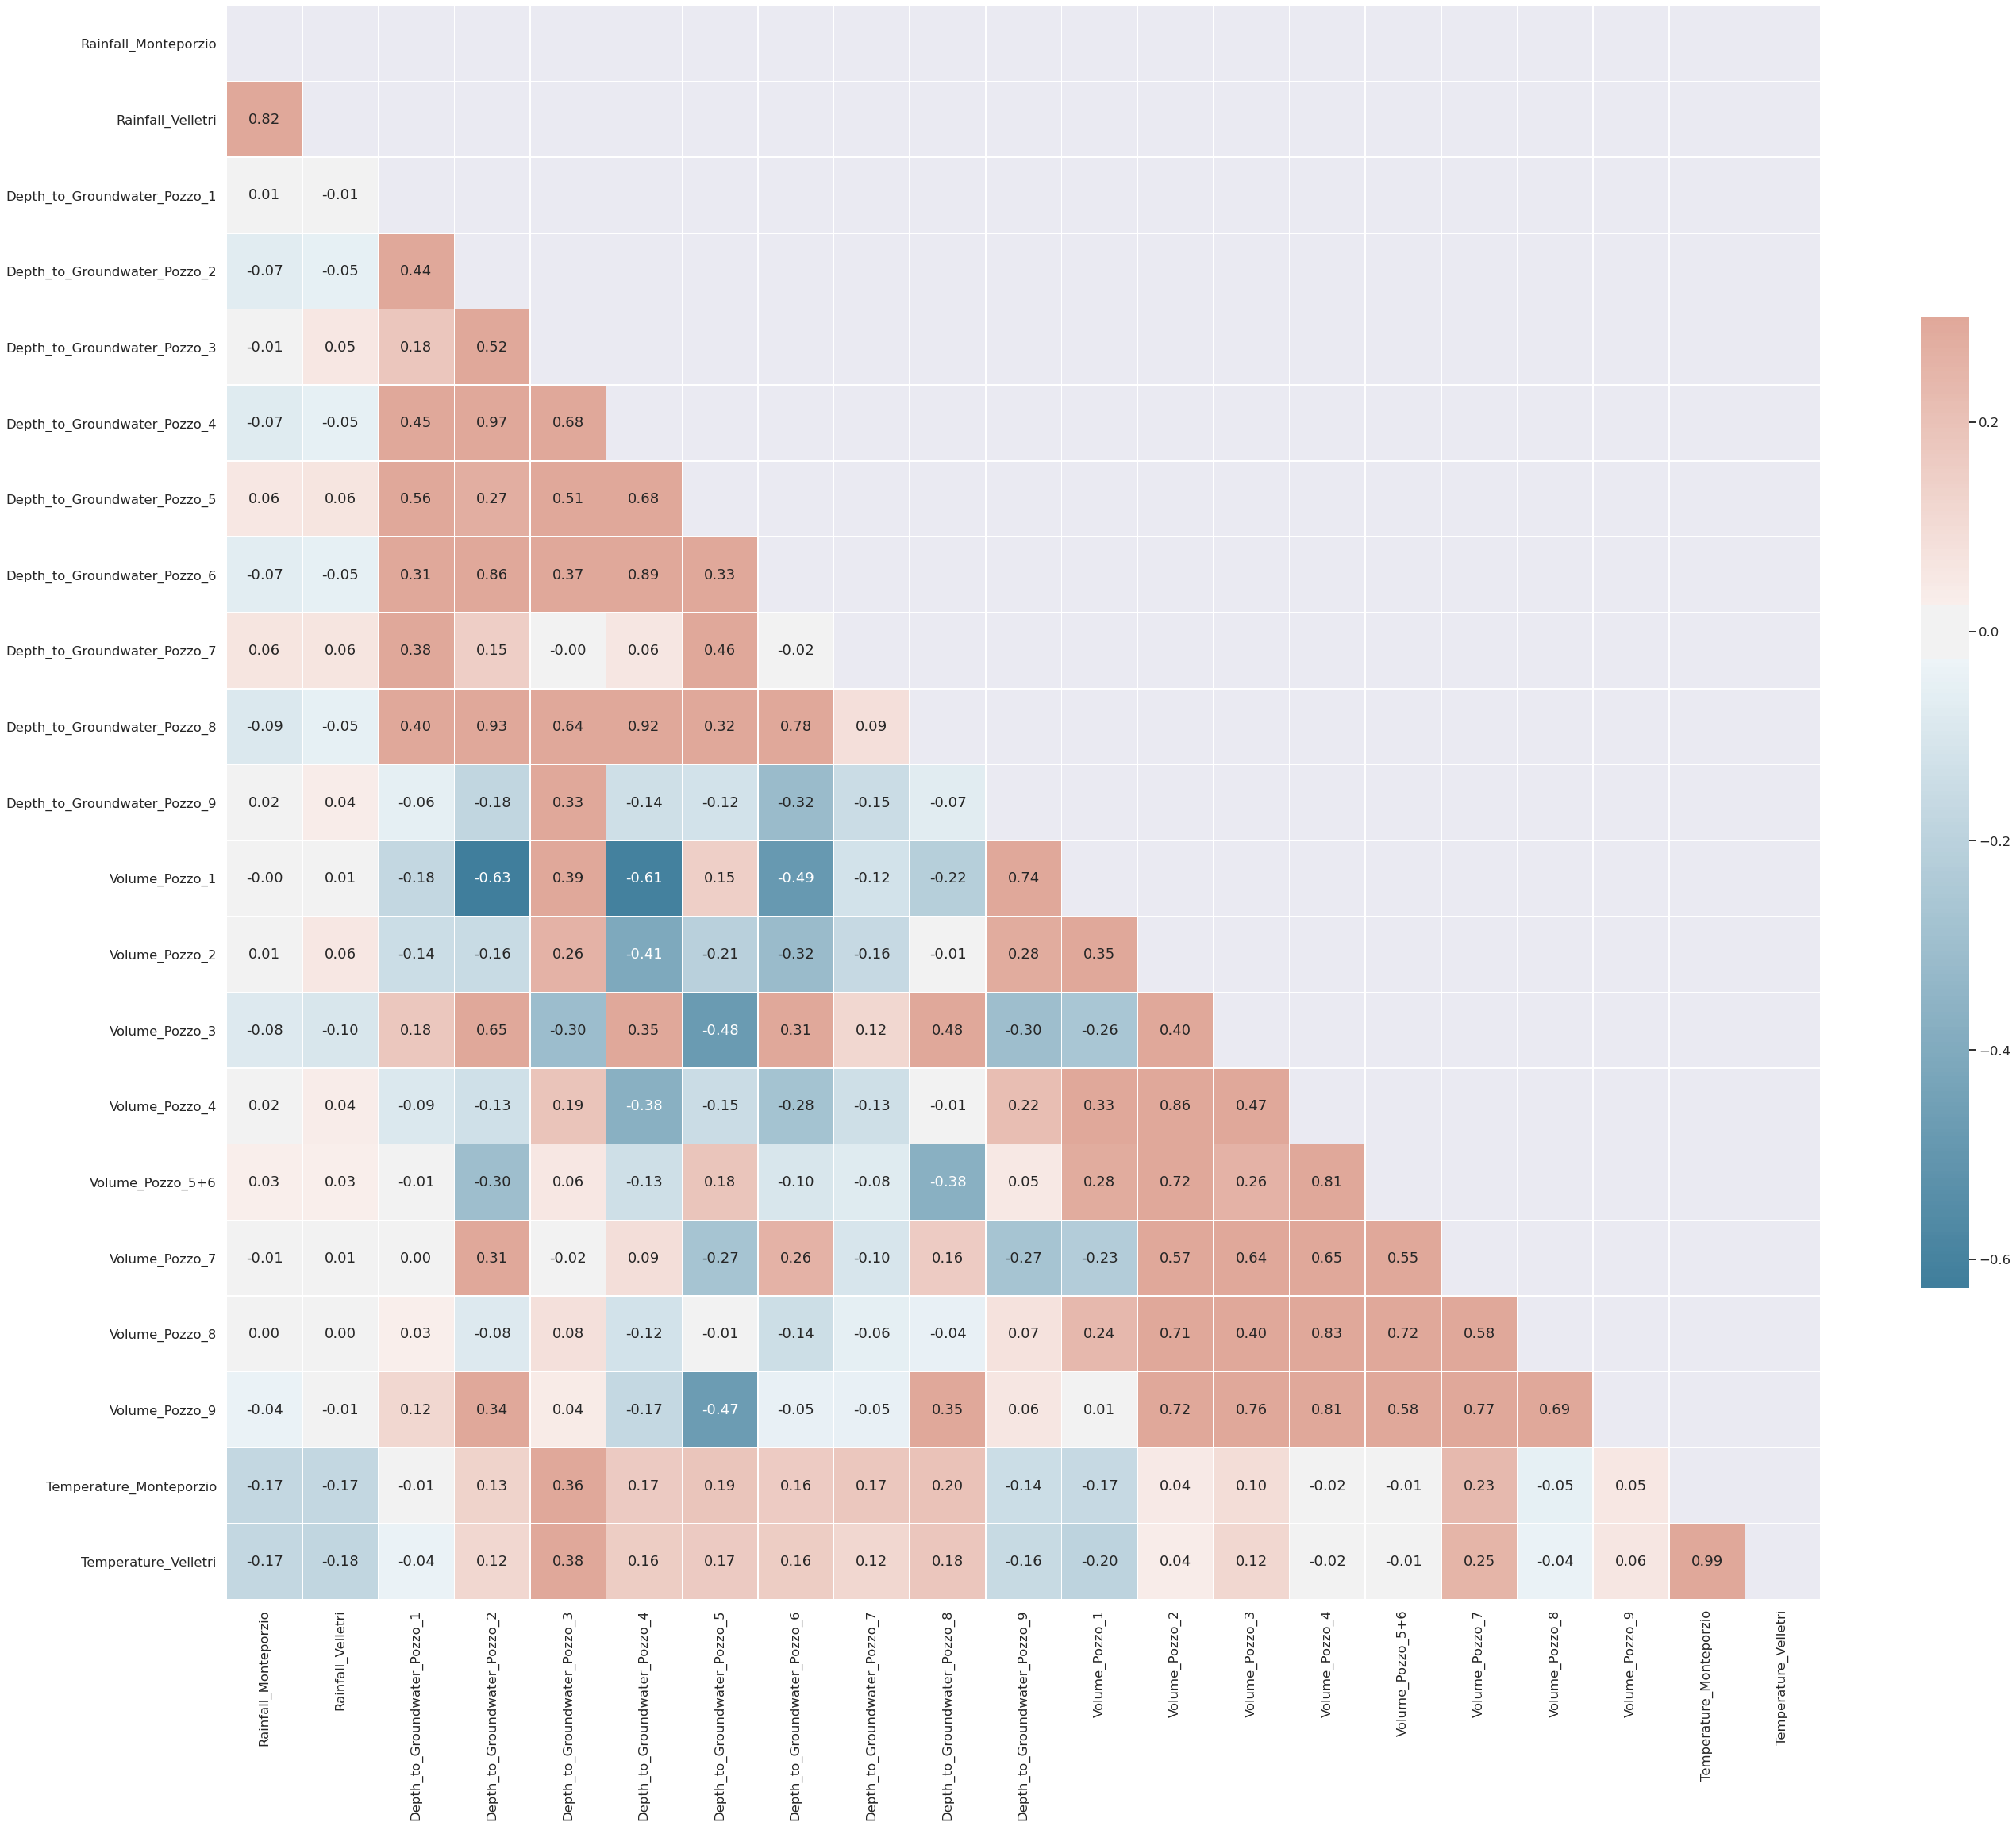

In [109]:
fig, ax = plt.subplots(figsize=(45, 45))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
au = 'Doganella_aquifer'
corr = Doganella_aquifer.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = ax)
plt.show()

There are only 2 rainfall features for this aquifer, with a variety of volume measures and a ton of (9 total!) depth meausures. As you can see from the heatmap above, some of the depths are strognly correlated with each other as are some of the volumes, but not some of the outcomes have little correlation with the other features.

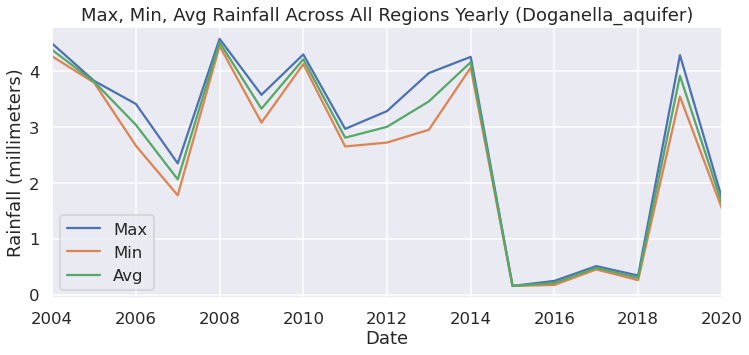

In [110]:
i = Doganella_aquifer
au = 'Doganella_aquifer'
rainy_cols = i.iloc[:, i.columns.str.contains('Rain')].reset_index()
temp = rainy_cols.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index()
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:,:3].max(axis = 1)
temp['min'] = temp.iloc[:,:3].min(axis = 1)
temp['avg'] = temp.iloc[:,:3].mean(axis = 1)
fig, ax = plt.subplots(figsize=(12, 5))
temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, Avg Rainfall Across All Regions Yearly (' + au + ')')
ax.set_ylabel('Rainfall (millimeters)')
plt.show()

The rainfall for the 2 regions present in this dataset roughly splits the difference between the Auser and Petrignano aquifers, with a good amount of volume in most years, but very little in 2015-2018

In [111]:
temp = aqs[2].reset_index()
temp = temp[list(aqs[2].reset_index().columns[np.r_[0:3, 12:22, 3:12]])]
a_pi = pd.DataFrame(index = temp.columns[1:13], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
a_pi.index.name = 'Region'


for i in range(1, 13):
    temp2 = temp.dropna(subset = [temp.columns[i]])
    temp2 = get_season_nogroup(temp2).dropna(subset = [temp.columns[i]])
    x = temp2['Season']
    y = temp2.iloc[:, i]
    tempp = get_pi(x, y, 0.05, temp2)
    tempp = tempp.groupby('Season').mean().reset_index()
    a_pi.iloc[i - 1,:] = round(tempp.iloc[:,3:5], 3).values.tolist()
    
cols = list(a_pi.columns)
cols = [cols[-1]] + cols[:-1]
a_pi = a_pi[cols]
a_pi

,Winter,Spring,Summer,Autumn
Region,,,,
Rainfall_Monteporzio,"[3.044, 4.364]","[0.761, 1.091]","[1.522, 2.182]","[2.283, 3.273]"
Rainfall_Velletri,"[3.415, 4.816]","[0.854, 1.204]","[1.708, 2.408]","[2.562, 3.612]"
Volume_Pozzo_1,"[1180.588, 2678.48]","[295.147, 669.62]","[590.294, 1339.24]","[885.441, 2008.86]"
Volume_Pozzo_2,"[3582.7, 5506.575]","[895.675, 1376.644]","[1791.35, 2753.287]","[2687.025, 4129.931]"
Volume_Pozzo_3,"[3249.697, 5527.544]","[812.424, 1381.886]","[1624.849, 2763.772]","[2437.273, 4145.658]"
Volume_Pozzo_4,"[3695.168, 5615.466]","[923.792, 1403.866]","[1847.584, 2807.733]","[2771.376, 4211.599]"
Volume_Pozzo_5+6,"[6904.481, 10799.117]","[1726.12, 2699.779]","[3452.241, 5399.559]","[5178.361, 8099.338]"
Volume_Pozzo_7,"[2592.443, 4009.952]","[648.111, 1002.488]","[1296.222, 2004.976]","[1944.333, 3007.464]"
Volume_Pozzo_8,"[3830.988, 5793.899]","[957.747, 1448.475]","[1915.494, 2896.95]","[2873.241, 4345.424]"


We see above that in the two rainfalls are around the same for each season. However, we see that the volume 5+6 has the largest interval of all the volumes given.  

In [112]:
a_pi.to_csv('aquifer3.csv')

In [113]:
df = Doganella_aquifer
df = df.dropna()
aqui = 'Doganella_aquifer'
print('Linear regression PCA models for ' + aqui)
endog = df.columns[df.columns.str.contains('Depth')]
Y = df[endog]
exog = df.columns.difference(Y.columns)
X = df[exog].values
obs = []
for col in Y.columns:
    ytemp = Y[col].values
    components = len(exog) // 2
    rmse, residuals, pred =  lr(X, ytemp, components)
    obs.append(get_params(X, ytemp, df, False, endog))
    print("     RMSE when predicting the "+ str(col), rmse)

Linear regression PCA models for Doganella_aquifer
     RMSE when predicting the Depth_to_Groundwater_Pozzo_1 5.556
     RMSE when predicting the Depth_to_Groundwater_Pozzo_2 0.487
     RMSE when predicting the Depth_to_Groundwater_Pozzo_3 9.705
     RMSE when predicting the Depth_to_Groundwater_Pozzo_4 0.388
     RMSE when predicting the Depth_to_Groundwater_Pozzo_5 0.068
     RMSE when predicting the Depth_to_Groundwater_Pozzo_6 3.686
     RMSE when predicting the Depth_to_Groundwater_Pozzo_7 0.597
     RMSE when predicting the Depth_to_Groundwater_Pozzo_8 1.149
     RMSE when predicting the Depth_to_Groundwater_Pozzo_9 1.411


As you can see above, the RMSE for these models is varies quite a bit. For example, the 5th depth is two orders of magnitude less than the 3rd. This means that our linear model might be suitable for a few of the predictions, but not all.

In [114]:
print('Predicting Depth to Groundwater Pozzo 3 (Left) and Pozzo 8 (Right)')
multi_table([obs[2], obs[-2]])

Predicting Depth to Groundwater Pozzo 3 (Left) and Pozzo 8 (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
Volume_Pozzo_1,6.648,1.309,0.000
Volume_Pozzo_2,-6.503,1.318,0.000
Volume_Pozzo_3,-0.005,0.001,0.000
Volume_Pozzo_5+6,-0.005,0.001,0.000
Temperature_Monteporzio,-0.017,0.005,0.001
,Coefficient,Standard Error,P-Value
Predictor,,,
Volume_Pozzo_1,5.020,1.077,0.00
Volume_Pozzo_2,-5.032,1.084,0.00


 As you can see from the number of tables above, the Doganella aquifer has the most depth measurements by far: a total of 9! For all of them the largest coefficients are on volume Pozzo 1 &  volume Pozzo 2, and they have large positive coefficients with around 5 to 6 in most cases. 

In [115]:
obs[2].to_csv('aquifer3-1.csv')
obs[-2].to_csv('aquifer3-2.csv')

### Luco

In [116]:
aqs[3].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7487 entries, 2000-01-01 to 2020-06-30
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Rainfall_Simignano                   6822 non-null   float64
 1   Rainfall_Siena_Poggio_al_Vento       951 non-null    float64
 2   Rainfall_Mensano                     1722 non-null   float64
 3   Rainfall_Montalcinello               6525 non-null   float64
 4   Rainfall_Monticiano_la_Pineta        2205 non-null   float64
 5   Rainfall_Sovicille                   6657 non-null   float64
 6   Rainfall_Ponte_Orgia                 1260 non-null   float64
 7   Rainfall_Scorgiano                   3036 non-null   float64
 8   Rainfall_Pentolina                   2116 non-null   float64
 9   Rainfall_Monteroni_Arbia_Biena       3104 non-null   float64
 10  Depth_to_Groundwater_Podere_Casetta  3346 non-null   float64
 11  Depth_to_Gro

Above, we see the information for the dataset of aquifer Luco. The variables that we want to study are the four depth to groundwater variables against the other variables. However, we see that the depth to groundwater variables have around 1000-3000 observations while the other predictor variables have anywhere from 1000-7000 observations. Because with an unknown outcome value, we are unable to utilize the observation, we drop any observation day that is missing values in all four depth to groundwater measurements. 

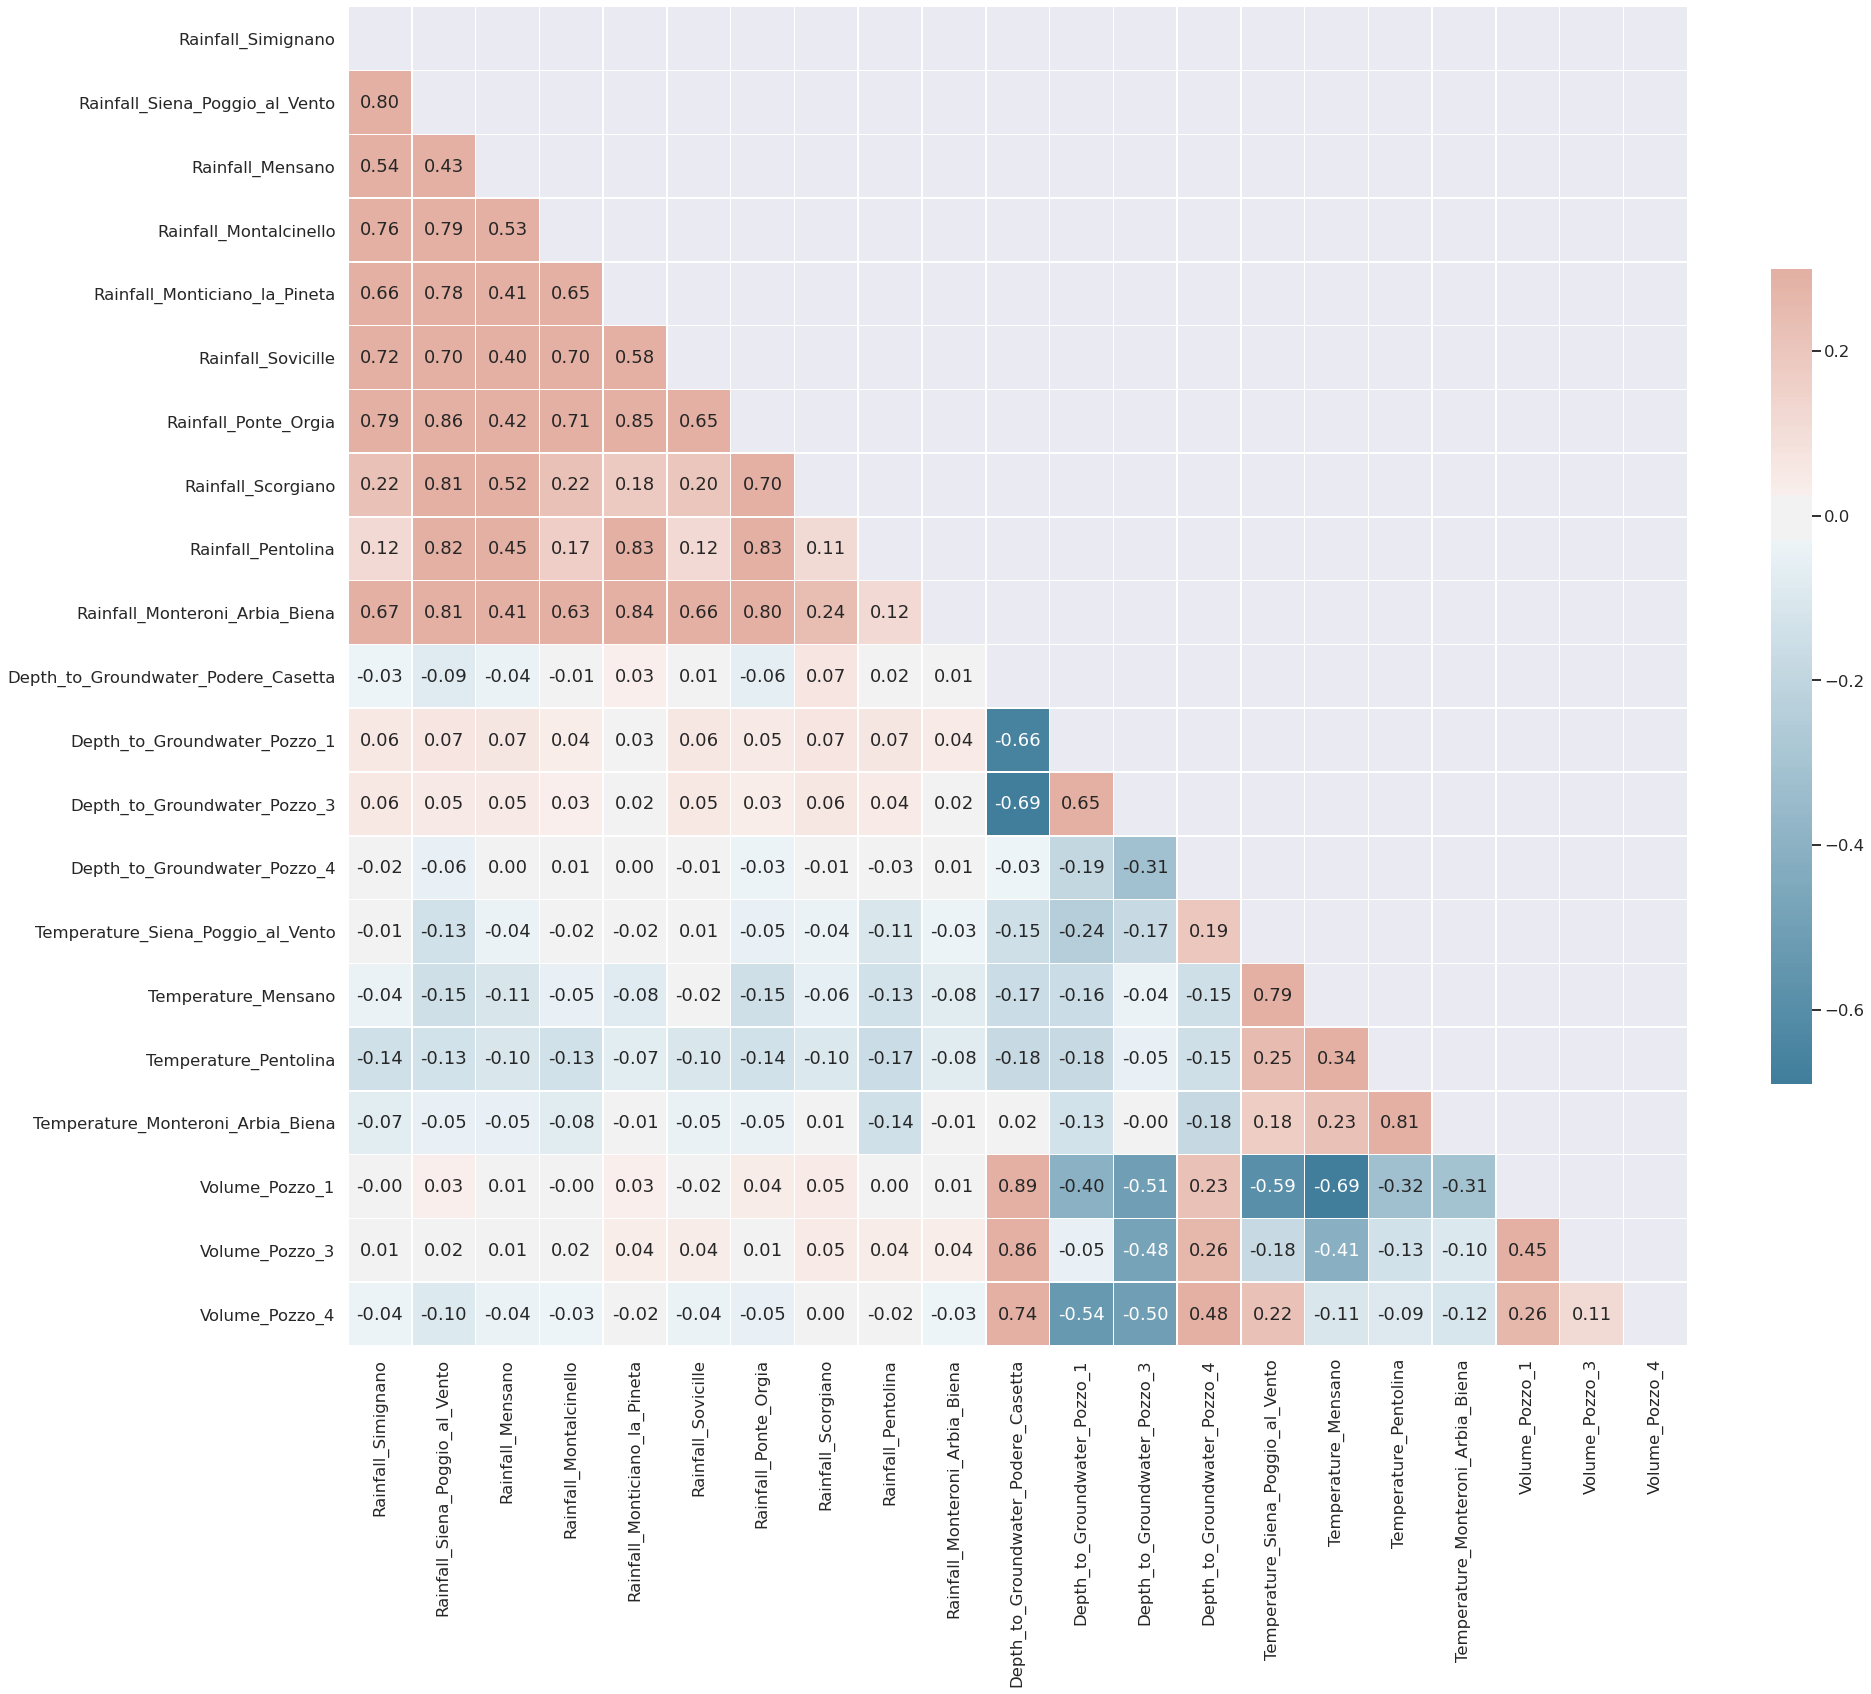

In [117]:
aqs[3].dropna(subset = ['Depth_to_Groundwater_Podere_Casetta', 'Depth_to_Groundwater_Pozzo_1', 
                      'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4'], how = 'all', inplace = True)

fig, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
au = 'Luco_aquifer'
corr = aqs[3].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, 
            center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = ax)
plt.show()

As you can see from the heatmap above, most of the features in this dataset have small (absolute) correlation, with lots of correlation with the same variable (ie. rainfall in one region is strongly correlated with rainfall in another region, but not with manyo of the other types of features).

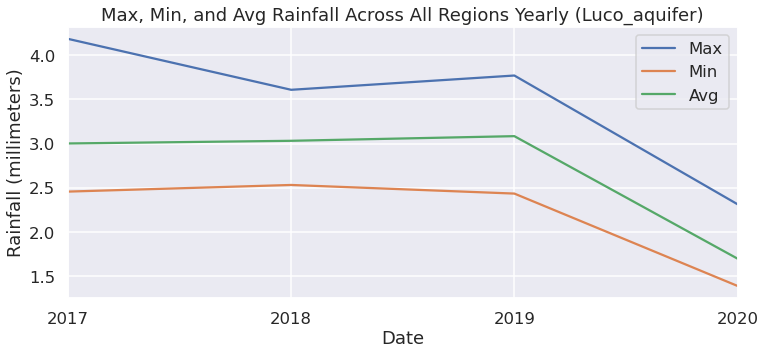

In [118]:
i = Luco_aquifer
au = 'Luco_aquifer'
rainy_cols = i.iloc[:, i.columns.str.contains('Rain')].reset_index()
temp = rainy_cols.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index()
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:,:11].max(axis = 1)
temp['min'] = temp.iloc[:,:11].min(axis = 1)
temp['avg'] = temp.iloc[:,:11].mean(axis = 1)
fig, ax = plt.subplots(figsize=(12, 5))
temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, and Avg Rainfall Across All Regions Yearly (' + au + ')')
ax.set_ylabel('Rainfall (millimeters)')
plt.show()

As you can see, this dataset has by far the fewest number of observations, with only 3 years of data present. The rainfall numbers seem roughly consistent with the Doganella aquifer, although there are far more rainfall regions present in this dataset

In [119]:
temp = aqs[3].reset_index()
temp = temp[list(aqs[3].reset_index().columns[np.r_[0:11, 15:22, 11:15]])]
a_pi = pd.DataFrame(index = temp.columns[1:18], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
a_pi.index.name = 'Region'

for i in range(1, 18):
    temp2 = temp.dropna(subset = [temp.columns[i]])
    temp2 = get_season_nogroup(temp2).dropna(subset = [temp.columns[i]])
    x = temp2['Season']
    y = temp2.iloc[:, i]
    tempp = get_pi(x, y, 0.05, temp2)
    tempp = tempp.groupby('Season').mean().reset_index()
    a_pi.iloc[i - 1,:] = round(tempp.iloc[:,3:5], 3).values.tolist()
    
cols = list(a_pi.columns)
cols = [cols[-1]] + cols[:-1]
a_pi = a_pi[cols]
a_pi

,Winter,Spring,Summer,Autumn
Region,,,,
Rainfall_Simignano,"[2.713, 4.317]","[0.678, 1.079]","[1.357, 2.159]","[2.035, 3.238]"
Rainfall_Siena_Poggio_al_Vento,"[1.167, 3.213]","[0.292, 0.803]","[0.583, 1.607]","[0.875, 2.41]"
Rainfall_Mensano,"[1.653, 4.654]","[0.413, 1.164]","[0.826, 2.327]","[1.24, 3.491]"
Rainfall_Montalcinello,"[2.742, 4.308]","[0.685, 1.077]","[1.371, 2.154]","[2.056, 3.231]"
Rainfall_Monticiano_la_Pineta,"[2.634, 5.231]","[0.658, 1.308]","[1.317, 2.616]","[1.975, 3.923]"
Rainfall_Sovicille,"[2.532, 4.146]","[0.633, 1.037]","[1.266, 2.073]","[1.899, 3.11]"
Rainfall_Ponte_Orgia,"[2.139, 4.666]","[0.535, 1.167]","[1.07, 2.333]","[1.604, 3.5]"
Rainfall_Scorgiano,"[3.055, 6.115]","[0.764, 1.529]","[1.528, 3.057]","[2.292, 4.586]"
Rainfall_Pentolina,"[3.743, 20.617]","[0.936, 5.154]","[1.872, 10.309]","[2.807, 15.463]"


Above, we see the prediction intervals of the predictor variables. The region of Pentolina has an extremely large interval for the winter months with as much as 30.617 millimeters of rainfall. We believe that this large interval be my due to a few outliers. 

In [120]:
a_pi.to_csv('aquifer4.csv')

In [121]:
df = Luco_aquifer
df = df.dropna()
aqui = 'Luco_aquifer'
print('Linear regression PCA models for ' + aqui)
endog = df.columns[df.columns.str.contains('Depth')]
Y = df[endog]
exog = df.columns.difference(Y.columns)
X = df[exog].values
obs = []
for col in Y.columns:
    ytemp = Y[col].values
    components = len(exog) // 2
    rmse, residuals, pred =  lr(X, ytemp, components)
    obs.append(get_params(X, ytemp, df, False, endog))
    print("     RMSE when predicting the "+ str(col), rmse)

Linear regression PCA models for Luco_aquifer
     RMSE when predicting the Depth_to_Groundwater_Podere_Casetta 0.211
     RMSE when predicting the Depth_to_Groundwater_Pozzo_1 0.637
     RMSE when predicting the Depth_to_Groundwater_Pozzo_3 0.525
     RMSE when predicting the Depth_to_Groundwater_Pozzo_4 1.063


Above, the RMSE for these particular models is somewhat good. Meaning that they are close to the threshold of 0.5 with the exception of predicting the depth to groundwater at Pozzo 4. This may mean that our linear regression model is doing well for the variables given in predicting the first three depths to groundwater while for the last one, we may not have enough variables to accurately predict. 

In [122]:
print('Predicting Depth to Groundwater Podere Casetta (Left) and Pozzo 1 (Right)')
multi_table([obs[0], obs[1]])

Predicting Depth to Groundwater Podere Casetta (Left) and Pozzo 1 (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
Temperature_Siena_Poggio_al_Vento,-0.308,0.049,0.000
Temperature_Mensano,0.113,0.028,0.000
Temperature_Pentolina,0.148,0.071,0.037
Volume_Pozzo_1,0.024,0.002,0.000
Volume_Pozzo_3,0.005,0.002,0.001
Volume_Pozzo_4,0.014,0.001,0.000
,Coefficient,Standard Error,P-Value
Predictor,,,
Temperature_Siena_Poggio_al_Vento,-0.503,0.110,0.000


As you can see from the above tables for the Luco aquifer, the largest coefficient (in absolute terms) is temperature, with Siena Poggio al Vento being largest for the first few depths.  As you can see from the other coefficients, they do not seem to be very predictive, with much smaller relative coefficients. 

In [123]:
obs[0].to_csv('aquifer4-1.csv')
obs[1].to_csv('aquifer4-2.csv')

## Water Springs

### Amiata

In [124]:
spring_amiata.dropna(how = 'all',inplace = True)
spring_lupa.dropna(how = 'all',inplace = True)
spring_madonna.dropna(how = 'all',inplace = True)
spring_amiata['Date'] = pd.to_datetime(spring_amiata['Date'], dayfirst = True)
spring_lupa['Date'] = pd.to_datetime(spring_lupa['Date'], dayfirst = True)
spring_madonna['Date'] = pd.to_datetime(spring_madonna['Date'], dayfirst = True)
spring_amiata.set_index('Date', inplace = True)
spring_lupa.set_index('Date', inplace = True)
spring_madonna.set_index('Date', inplace = True)


In [125]:
spring_amiata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7487 entries, 2000-01-01 to 2020-06-30
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Rainfall_Castel_del_Piano              6291 non-null   float64
 1   Rainfall_Abbadia_S_Salvatore           3586 non-null   float64
 2   Rainfall_S_Fiora                       2633 non-null   float64
 3   Rainfall_Laghetto_Verde                2865 non-null   float64
 4   Rainfall_Vetta_Amiata                  2212 non-null   float64
 5   Depth_to_Groundwater_S_Fiora_8         3569 non-null   float64
 6   Depth_to_Groundwater_S_Fiora_11bis     3594 non-null   float64
 7   Depth_to_Groundwater_David_Lazzaretti  3242 non-null   float64
 8   Temperature_Abbadia_S_Salvatore        3583 non-null   float64
 9   Temperature_S_Fiora                    7487 non-null   float64
 10  Temperature_Laghetto_Verde             3604 non-null  

Above, we see that there are a varying amount of missing data. With a total of 7487 observations, all of the variables are missing over half of the observations, i.e missing 3500 or more days during the study. Because we want to study the relationship between the variables and the flow rate, we drop any missing observations in the flow rate variables because a missing data in the flow rate variable is meaningless, as we are unable to study any relationship. 

In [126]:
spring_amiata.dropna(subset=['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'], 
                     how = 'all', inplace = True)
spring_amiata.reset_index(inplace = True)

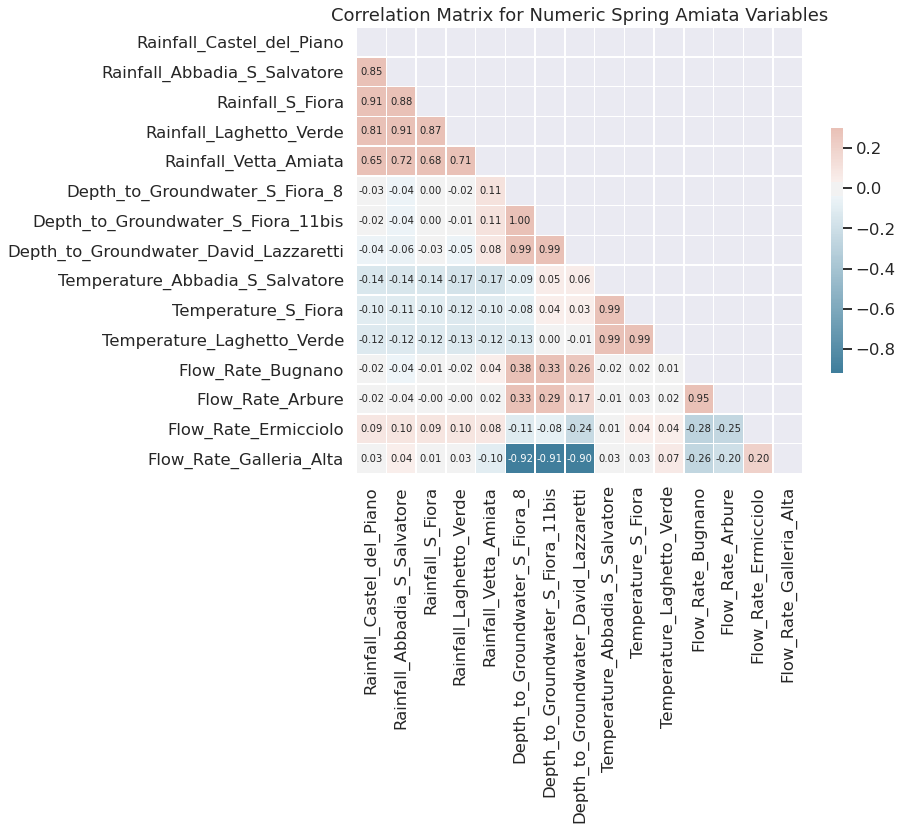

In [127]:
fig, ax = plt.subplots(figsize=(10, 9))
corr = spring_amiata.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) #to cover upper triangular
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = ax, annot_kws={"size": 10})
ax.set_title('Correlation Matrix for Numeric Spring Amiata Variables')
plt.show()

In this dataset of analyzing water spring Amiata, we see that the three most correlated variables with the flow rate of Galleria Alta are the three depth to groundwater variables. Additionally, they are also the most correlated with the other three flow rates as well. Furthermore, we notice in the five rainfalls, they are fairly correlated with each other, i.e multicollinearity. 

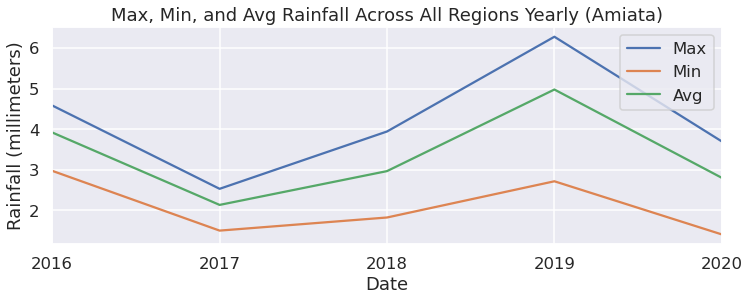

In [128]:
temp = spring_amiata.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:,:6].max(axis = 1)
temp['min'] = temp.iloc[:,:6].min(axis = 1)
temp['avg'] = temp.iloc[:,:6].mean(axis = 1)

fig, ax = plt.subplots(figsize=(12, 4))

temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, and Avg Rainfall Across All Regions Yearly (Amiata)')
ax.set_ylabel('Rainfall (millimeters)')

plt.show()

Above, we see the maximum, minimum, and average yearly rainfall across all five regions. We note that there was a decrease in rainfall in year 2017 and a fairly large increase in the year 2019. 

In [129]:
a_pi = pd.DataFrame(index = spring_amiata.columns[1:12], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
a_pi.index.name = 'Region'

for i in range(1, 12):
    amiata = spring_amiata.dropna(subset = [spring_amiata.columns[i]])
    amiata = get_season_nogroup(amiata)
    amiata = amiata.fillna(0)
    x = amiata['Season']
    y = amiata.iloc[:, i]
    temp = get_pi(x, y, 0.05, amiata)
    temp = temp.groupby('Season').mean().reset_index()
    a_pi.iloc[i - 1,:] = round(temp.iloc[:,3:5], 3).values.tolist()

cols = list(a_pi.columns)
cols = [cols[-1]] + cols[:-1]
a_pi = a_pi[cols]
print('Prediction Intervals for Amiata Predictors')
a_pi

Prediction Intervals for Amiata Predictors


,Winter,Spring,Summer,Autumn
Region,,,,
Rainfall_Castel_del_Piano,"[2.541, 5.037]","[0.635, 1.259]","[1.27, 2.519]","[1.906, 3.778]"
Rainfall_Abbadia_S_Salvatore,"[3.633, 7.172]","[0.908, 1.793]","[1.817, 3.586]","[2.725, 5.379]"
Rainfall_S_Fiora,"[3.31, 7.065]","[0.827, 1.766]","[1.655, 3.533]","[2.482, 5.299]"
Rainfall_Laghetto_Verde,"[3.996, 7.972]","[0.999, 1.993]","[1.998, 3.986]","[2.997, 5.979]"
Rainfall_Vetta_Amiata,"[2.986, 5.0]","[0.747, 1.25]","[1.493, 2.5]","[2.24, 3.75]"
Depth_to_Groundwater_S_Fiora_8,"[-54.596, -29.134]","[-13.649, -7.284]","[-27.298, -14.567]","[-40.947, -21.851]"
Depth_to_Groundwater_S_Fiora_11bis,"[-74.04, -39.55]","[-18.51, -9.888]","[-37.02, -19.775]","[-55.53, -29.663]"
Depth_to_Groundwater_David_Lazzaretti,"[-488.26, -323.373]","[-122.065, -80.843]","[-244.13, -161.687]","[-366.195, -242.53]"
Temperature_Abbadia_S_Salvatore,"[7.389, 19.884]","[1.847, 4.971]","[3.694, 9.942]","[5.541, 14.913]"


Above we see that the rainfall at Laghetoo Verde is the greatest in millimeters and that the depth to groundwater at David Lazzaretti is the deepest. 

In [130]:
a_pi.to_csv('spring1.csv')

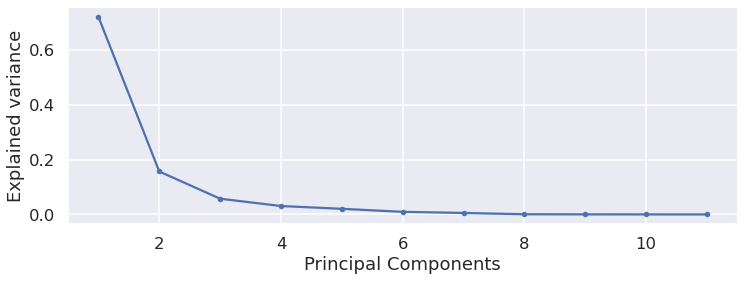

In [131]:
#PCA dimensionality reduction

array = spring_amiata.dropna().values
X = array[:,1:12]

pca = PCA(n_components = 11)
fit = pca.fit(X)
temp = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance'], index = list(range(1, len(pca.explained_variance_ratio_) + 1)))

fig, ax = plt.subplots(figsize=(12, 4))
temp.plot(kind = 'line', style='.-', legend = False, ax = ax)
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')

plt.show()

To fix the problem of multicollinearity and to reduce the number of variables in our regression model, we utilize principal component analysis. Above we plot the different principal components and the corresponding variances. We see that just by using 5 principal components, we are able to explain most of the variance in our dataset. 

In [132]:
array = spring_amiata.dropna().values
X = array[:,1:12]
y = array[:, 12]
rmse, res1, y_pred1 = lr(X, y, 6)
df1 = get_params(X, y, spring_amiata.dropna())
print('RMSE when predicting the Flow Rate of Bugnano:', rmse)

X = array[:,1:12]
y = array[:, 13]
rmse, res2, y_pred2 = lr(X, y, 6)
df2 = get_params(X, y, spring_amiata.dropna())
print('RMSE when predicting the Flow Rate of Arbure:', rmse)

X = array[:,1:12]
y = array[:, 14]
rmse, res3, y_pred3 = lr(X, y, 6)
df3 = get_params(X, y, spring_amiata.dropna())
print('RMSE when predicting the Flow Rate of Ermicciolo:', rmse)

X = array[:,1:12]
y = array[:, 15]
rmse, res4, y_pred4 = lr(X, y, 6)
df4 = get_params(X, y, spring_amiata.dropna())
print('RMSE when predicting the Flow Rate of Galleria Alta:', rmse)

RMSE when predicting the Flow Rate of Bugnano: 0.056
RMSE when predicting the Flow Rate of Arbure: 0.44
RMSE when predicting the Flow Rate of Ermicciolo: 1.888
RMSE when predicting the Flow Rate of Galleria Alta: 1.137


Above, we see the root mean squared errors when predicting the four flow rates for the water spring Amiata. When using a linear regression to predict the first two flow rates of Bugnano and Arbure, we get a low error, meaning that the linear regression model was pretty accurate in predicting the flow rate. As for the last two, flow rates of Ermicciolo and Galleria Alta, the root mean squared error is fairly high. Referring back to the correlation matrix above, we see that there are variables correlated with these two outcome variables; however, with a root mean squared error this high, it might suggest that a linear model does not fit the data as well. 

In [133]:
print('Predicting flow rate of Bugnano (Left) and flow rate of Arbure (Right)')
multi_table([df1, df2])

Predicting flow rate of Bugnano (Left) and flow rate of Arbure (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Abbadia_S_Salvatore,-0.002,0.001,0.035
Rainfall_Laghetto_Verde,0.002,0.000,0.000
Rainfall_Vetta_Amiata,0.034,0.014,0.017
Depth_to_Groundwater_S_Fiora_8,0.109,0.006,0.000
Depth_to_Groundwater_S_Fiora_11bis,-0.022,0.002,0.000
,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Laghetto_Verde,0.013,0.004,0.0
Depth_to_Groundwater_S_Fiora_8,0.965,0.045,0.0


In [134]:
print('Predicting flow rate of Ermicciolo (Left) and Flow rate of Galleria Alta (Right)')
multi_table([df3, df4])

Predicting flow rate of Ermicciolo (Left) and Flow rate of Galleria Alta (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Vetta_Amiata,5.044,0.299,0.000
Depth_to_Groundwater_S_Fiora_11bis,-0.603,0.047,0.000
Depth_to_Groundwater_David_Lazzaretti,-0.193,0.071,0.007
Temperature_S_Fiora,0.270,0.093,0.004
,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Vetta_Amiata,-3.910,0.171,0.000
Depth_to_Groundwater_S_Fiora_8,3.682,0.069,0.000
Depth_to_Groundwater_S_Fiora_11bis,-0.066,0.027,0.014


Above, we see the coefficients of all four regressions for each flow rate at difference locations. Common throughout all of the four is the depth to groundwater at South Fiora 11 bis with the depth to ground water at South Fiora 8 common throughout three of the four. This was not surprising because looking at the correlation matrix, we see that these two depth to groundwater locations are extremely correlated with each four of the flow rates. However, if looking at the correlation between these two depth to groundwater locations, we notice that there is an indication of a perfect correlation. Hence, we are unsure of which of these predictors is more significant because the presence of one affects the presence of the other. 

In [135]:
df1.to_csv('spring1-1.csv')
df2.to_csv('spring1-2.csv')
df3.to_csv('spring1-3.csv')
df4.to_csv('spring1-4.csv')

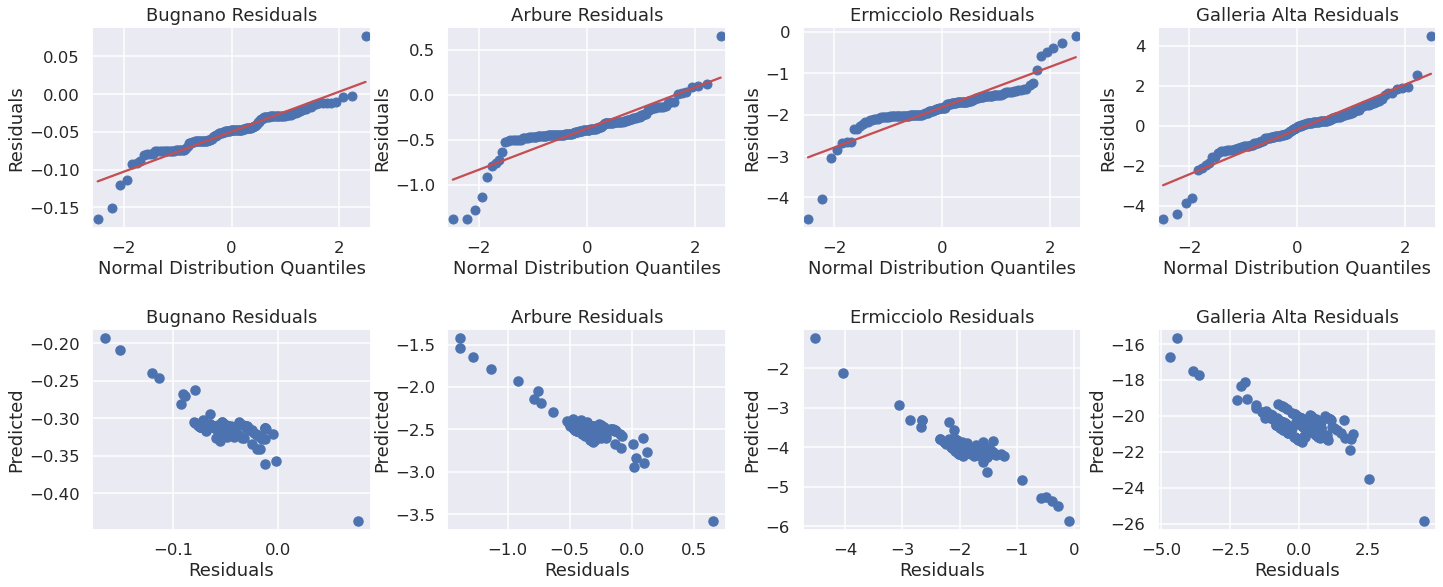

In [136]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

sm.qqplot(res1, line='s', ax = ax[0][0])
ax[0][0].set_title('Bugnano Residuals')
ax[0][0].set_ylabel('Residuals')
ax[0][0].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res2, line='s', ax = ax[0][1])
ax[0][1].set_title('Arbure Residuals')
ax[0][1].set_ylabel('Residuals')
ax[0][1].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res3, line='s', ax = ax[0][2])
ax[0][2].set_title('Ermicciolo Residuals')
ax[0][2].set_ylabel('Residuals')
ax[0][2].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res4, line='s', ax = ax[0][3])
ax[0][3].set_title('Galleria Alta Residuals')
ax[0][3].set_ylabel('Residuals')
ax[0][3].set_xlabel('Normal Distribution Quantiles')


ax[1][0].scatter(res1, y_pred1)
ax[1][0].set_title('Bugnano Residuals')
ax[1][0].set_xlabel('Residuals')
ax[1][0].set_ylabel('Predicted')

ax[1][1].scatter(res2, y_pred2)
ax[1][1].set_title('Arbure Residuals')
ax[1][1].set_xlabel('Residuals')
ax[1][1].set_ylabel('Predicted')

ax[1][2].scatter(res3, y_pred3)
ax[1][2].set_title('Ermicciolo Residuals')
ax[1][2].set_xlabel('Residuals')
ax[1][2].set_ylabel('Predicted')

ax[1][3].scatter(res4, y_pred4)
ax[1][3].set_title('Galleria Alta Residuals')
ax[1][3].set_xlabel('Residuals')
ax[1][3].set_ylabel('Predicted')



plt.show()

When looking at the residuals, to confirm that a linear regression is correct for the data, we see the first and the last residuals, the regions of Bugnano and Galleria Alta are fairly normal. As for Arbure and Ernicciolo, the distributions of the residuals are somewhat normal with many deviations from the normal distribution. Looking at the scatter plot of the residuals vs the predicted values, we see that there seems to be a strong negative correlation instead of a random scatter. This hints at the decision that our data is not right for a linear regression. 

### Lupa and Madonna Di Canneto

In [137]:
spring_lupa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4199 entries, 2009-01-01 to 2020-06-30
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rainfall_Terni  4199 non-null   float64
 1   Flow_Rate_Lupa  3817 non-null   float64
dtypes: float64(2)
memory usage: 98.4 KB


In [138]:
spring_madonna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3104 entries, 2012-01-01 to 2020-06-30
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rainfall_Settefrati           2557 non-null   float64
 1   Temperature_Settefrati        2557 non-null   float64
 2   Flow_Rate_Madonna_di_Canneto  1387 non-null   float64
dtypes: float64(3)
memory usage: 97.0 KB


Above we see the information about null values in both the Lupa and Madonna di Canneto datasets. In both datasets, because we want to predict the flow rate from the other variables given, any null values that the flow rate contains is dropped. We had decided on this decision because with an unknown outcome value, we are unable to predict or make assumptions on. While this may decrease the accuracy of our model and increase the error, we did not want to impute the value, possibly feeding the model incorrect information.

In [139]:
#Dropping values

spring_lupa.dropna(inplace = True)
spring_lupa.reset_index(inplace = True)

spring_madonna.reset_index(inplace = True)

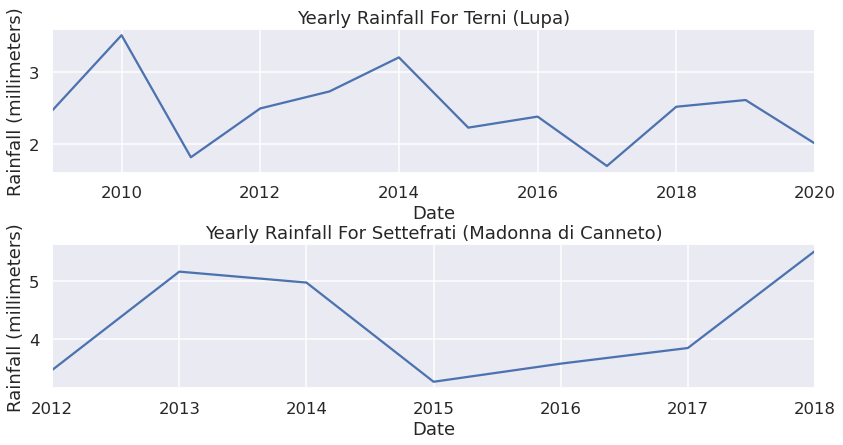

In [140]:
#Lupa
temp = spring_lupa.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

temp.plot(kind = 'line', x = 'Date', y = 'Rainfall_Terni', ax = ax[0], legend = False)
ax[0].set_title('Yearly Rainfall For Terni (Lupa)')
ax[0].set_ylabel('Rainfall (millimeters)')


#Madonna
temp = spring_madonna.dropna(subset=['Rainfall_Settefrati'])
temp = temp.groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month


temp.plot(kind = 'line', x = 'Date', y = 'Rainfall_Settefrati', ax = ax[1], legend = False)
ax[1].set_title('Yearly Rainfall For Settefrati (Madonna di Canneto)')
ax[1].set_ylabel('Rainfall (millimeters)')

plt.show()

Above, we plot the yearly rainfall for the rainfall regions of the water spring Lupa (Top) and Madonna di Canneto (bottom). In both of these graphs, unlike the other datasets, we only plot a single region because there are very limited numbers of variables in both of these datasets, hence, we are unable to take the maximum, minimum, or average for the entire year. 

In the region of Terni for the water spring Lupa, we see an overall decrease in the rainfall from the year 2010 and 2020. As for the water spring Madonna di Canneto, we see almost a steady rainfall from year 2012 to 2018 with an all time low yearly rainfall in year 2015. 

In [141]:
#Confidence Intervals
#Lupa
lupa = get_season_nogroup(spring_lupa.dropna())

l_pi = pd.DataFrame(columns = spring_lupa.columns[1:2], index = [ 'Winter', 'Spring', 'Summer', 'Autumn'])
l_pi.index.name = 'Season'

for i in range(1, 2):
    x = lupa['Season']
    y = lupa.iloc[:, i]
    temp = get_pi(x, y, 0.05, lupa)
    temp = temp.groupby('Season').mean().reset_index()
    l_pi.iloc[:,i - 1] = round(temp.iloc[:,3:5], 3).values.tolist()
    
l_pi = l_pi.apply(np.roll, shift=1) #Calculated with 3, 6, 9, 12 3 being spring 9 being autumn

#Madonna di Canneto
madonna = get_season_nogroup(spring_madonna.dropna())
madonna = madonna.fillna(0)

m_pi = pd.DataFrame(columns = spring_madonna.columns[1:3], index = [ 'Winter', 'Spring', 'Summer', 'Autumn'])
m_pi.index.name = 'Season'

for i in range(1, 3):
    x = madonna['Season']
    y = madonna.iloc[:, i]
    temp = get_pi(x, y, 0.05, madonna)
    temp = temp.groupby('Season').mean().reset_index()
    m_pi.iloc[:,i - 1] = round(temp.iloc[:,3:5], 3).values.tolist()
    
m_pi = m_pi.apply(np.roll, shift=1) #Calculated with 3, 6, 9, 12 3 being spring 9 being autumn

In [142]:
print('Prediction Intervals for Lupa (Left) Madonna di Canneto (Right) Predictors')
multi_table([l_pi, m_pi])

Prediction Intervals for Lupa (Left) Madonna di Canneto (Right) Predictors


In the two tables above, we see the prediction intervals in the predictor variables of the water spring Lupa (Left) and Madonna di Canneto (Right). It is no surprise that in both water springs, the Winter season is the one with the most rainfall. What is surprising is that the summer months, there is approximately twice as much rainfall that in the Spring. We hypothesize that the autumn months in Italy may begin earlier than in the USA, i.e the ending months of Summer, leading into Autumn, experience high rainfalls. 

In [143]:
l_pi.to_csv('spring2.csv')
m_pi.to_csv('spring3.csv')

In [144]:
array = spring_lupa.dropna().values
X = array[:,1]
y = array[:, 2]
X = X.reshape(-1, 1)
rmse, res1, y_pred1 = lr_nopca(X, y)
df1 = get_params(X, y, spring_lupa.dropna())
print('RMSE when predicting the Flow Rate of Lupa:', rmse)

array = spring_madonna.dropna().values
X = array[:,1:3]
y = array[:, 3]
rmse, res2, y_pred2 = lr(X, y, 2)
df2 = get_params(X, y, spring_madonna.dropna())
print('RMSE when predicting the Flow Rate of Madonna di Canneto:', rmse)

RMSE when predicting the Flow Rate of Lupa: 15.792
RMSE when predicting the Flow Rate of Madonna di Canneto: 18.652


Above, we see the root mean squared error of predicting both flow rates is extremely high. While this might suggest that a linear regression is not suitable for these two datasets, we are unsure of whether this is true or not. When looking at the data for both Lupa and Madonna di Canneto, we see that we needed to drop about a few hundred observations for Lupa and around half for Madonna di Canneto. Therefore, this bias in our data may have led calculation of the error to be high, when in reality if the model was trained with more complete data, a linear regression may be suitable. 

In [145]:
print('Predicting Flow Rate of Lupa (Left) and flow rate of Mandonna Di Canneto (Right)')
multi_table([df1, df2])

Predicting Flow Rate of Lupa (Left) and flow rate of Mandonna Di Canneto (Right)


,Coefficient,Standard Error,P-Value
Predictor,,,
,Coefficient,Standard Error,P-Value
Predictor,,,
Rainfall_Settefrati,15.77,0.267,0.0


When predicting the flow rate for Lupa, we did not find any significant predictors. This is because the dataset for the Lupa spring was fairly small. For the Mandonna Di Canneto, we see that the rainfall for the region of Settefrati was pretty significant with a coefficient of 15.77; however, this may also be due to a small dataset, as the model has not seen much variation. 

In [146]:
df2.to_csv('spring3-1.csv')

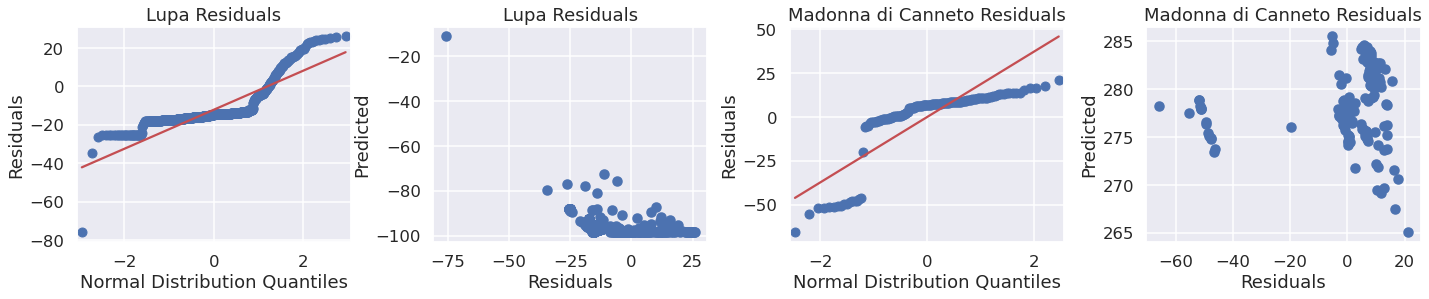

In [147]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)

sm.qqplot(res1, line='s', ax = ax[0])
ax[0].set_title('Lupa Residuals')
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res2, line='s', ax = ax[2])
ax[2].set_title('Madonna di Canneto Residuals')
ax[2].set_ylabel('Residuals')
ax[2].set_xlabel('Normal Distribution Quantiles')

ax[1].scatter(res1, y_pred1)
ax[1].set_title('Lupa Residuals')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Predicted')

ax[3].scatter(res2, y_pred2)
ax[3].set_title('Madonna di Canneto Residuals')
ax[3].set_xlabel('Residuals')
ax[3].set_ylabel('Predicted')


plt.show()

Above, we see the residuals plotted for the remaining two springs. It is no surprise that the residuals are neither normal nor random. The extremely large root mean square error informs us that a linear regression is not suitable for our data. Hence, looking at the residuals further confirms this fact. 

## Lakes

In [148]:
lake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


In [149]:
lake.info().to_csv('lake_info.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


AttributeError: 'NoneType' object has no attribute 'to_csv'

Before beginning our analysis, we want to identify any missing data in our observations. The above list highlights the number of null data in each variable present. We see that there are a total of 6603 entires for the lake data. however, 6 of these variables have the exact same number of missing data, i.e the study had not begun but the data for two other variables was available. Hence, we drop the 578 observations with missing data in these 6 columns.  

In [ ]:
lake.dropna(subset=['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 
                    'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Temperature_Le_Croci'], how = 'all', inplace = True)
lake.reset_index(drop = True, inplace = True)
lake.loc[:, 'Date'] = pd.to_datetime(lake['Date'], dayfirst = True)

In [ ]:
corr = lake.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) #to cover upper triangular
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, annot_kws={"size": 10})
plt.show()

From the correlation matrix, we see that the temperature is the most correlated with the flow rate and the lake level. We found this to be surprising because a positive correlation between the temperature and the lake level meant that as the temperature rose, so did the lake level. We expected at the very least the correlation be a negative value because as the temperature rises, the more water evaporates, and hence a lower lake level. 

In [ ]:
temp = lake.groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:,:6].max(axis = 1)
temp['min'] = temp.iloc[:,:6].min(axis = 1)
temp['avg'] = temp.iloc[:,:6].mean(axis = 1)

fig, ax = plt.subplots(figsize=(12, 4))

temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, and Avg Rainfall Across All Regions Yearly (Lake)')
ax.set_ylabel('Rainfall (millimeters)')

plt.show()

Above, we see in the winters of year 2010 and 2014, there was a dramatic increase in the rainfall. Additionally, we notice that the rainfall of year 2012 was far lower than other years in the study. 

In [ ]:
lake2 = get_season_nogroup(lake)
l_pi = pd.DataFrame(columns = lake.columns[1:7], index = [ 'Winter', 'Spring', 'Summer', 'Autumn'])
l_pi.index.name = 'Season'
for i in range(1, 7):
    x = lake2['Season']
    y = lake2.iloc[:, i]
    temp = get_pi(x, y, 0.05, lake2)
    temp = temp.groupby('Season').mean().reset_index()
    l_pi.iloc[:,i - 1] = round(temp.iloc[:,3:5], 3).values.tolist()
l_pi = l_pi.apply(np.roll, shift=1) 
l_pi

Because we want to identify what is the best way to extract water, we calculated the confidence intervals of each region in terms of rainfall or temperature for each season. For instance, we are 95% confidence that the South Piero region would have between 3.197 and 4.095 millimeters of rainfall during the Winter Season. 

In [ ]:
l_pi.to_csv('lake1.csv')

In [ ]:
lake3 = get_season_nogroup(lake)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
fig.tight_layout()

sns.regplot(x = 'Rainfall_S_Piero', y = 'Lake_Level', data = lake3, ax = ax[0])
sns.regplot(x = 'Rainfall_Cavallina', y = 'Lake_Level', data = lake3, ax = ax[1])
sns.regplot(x = 'Rainfall_Le_Croci', y = 'Flow_Rate', data = lake3, ax = ax[2])

plt.show()

Above, we see the regression plots for some predictors and outcome variables separately. We see that the first two plots do not show a linear relationship while the one on the very right shows some linearly relationship. Other variables follow the same behaviors, with some showing no linear relationship at all and some hinting at the existence of this relationship. 

In [ ]:
#PCA dimensionality reduction

array = lake.dropna().values
X = array[:,1:7]

pca = PCA(n_components = 6)
fit = pca.fit(X)
temp = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance'], index = list(range(1, len(pca.explained_variance_ratio_) + 1)))

fig, ax = plt.subplots(figsize=(12, 4))
temp.plot(kind = 'line', style='.-', legend = False, ax = ax)
plt.title('Principal Compnents vs Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')

plt.show()

Because our dataset has multiple predictor variables, carrying out principal component analysis (PCA) can aid in decreasing the dimension space with a trade off of variance. In the plot above of the variance explained by each component, we see that most of the variance in the data can be explained by 3 principal components. 

In [ ]:
array = lake.dropna().values
X = array[:,1:7]
y = array[:, 7]
rmse, res1, y_pred1 = lr(X, y, 3)
df1 = get_params(X, y, lake.dropna())
print('RMSE when predicting the Lake Level:', rmse)

X = array[:,1:7]
y = array[:, 8]
rmse, res2, y_pred2 = lr(X, y, 3)
df2 = get_params(X, y, lake.dropna())
print('RMSE when predicting the Flow Rate:', rmse)

Typically, when looking at the root mean squared error for predictions, we aim for a value that is less than 0.5. Above, we see that we resulted in an error value of 1.805 and 3.963 when predicting the lake level and flow rate, respectively. When referring back to the correlation matrix above, we see that all the five rainfalls and the temperature variable with the lake level do not have high correlations, less than 0.1. Hence, we believe that we are unable to use linear regression to predict the lake level. 

In [ ]:
print('Predicting the lake level (Left) and the flow rate (Right)')
multi_table([df1, df2])

Looking at the lake level (left) first, we see that the rainfall of Le Croci is an important predictor when predicting the rainfall. This was interesting because when just looking at the correlation matrices, there all variables had an extremely low correlation with the lake level. Moving on to the flow rate, we see that the rainfall at Cavallina and Le Croci are important predictors in our model. 

In [ ]:
df1.to_csv('lake1-1.csv')
df2.to_csv('lake1-2.csv')

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)

sm.qqplot(res1, line='s', ax = ax[0])
ax[0].set_title('Lake Level Residuals')
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Normal Distribution Quantiles')

sm.qqplot(res2, line='s', ax = ax[2])
ax[2].set_title('Flow Rate Residuals')
ax[2].set_ylabel('Residuals')
ax[2].set_xlabel('Normal Distribution Quantiles')

ax[1].scatter(res1, y_pred1)
ax[1].set_title('Lake Level Residuals')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Predicted')

ax[3].scatter(res2, y_pred2)
ax[3].set_title('Flow Rate Residuals')
ax[3].set_xlabel('Residuals')
ax[3].set_ylabel('Predicted')


plt.show()

When looking at the lake level residuals, the left two, we see that the residuals are neither normally distributed nor randomly scattered. In the scatter plot of lake level residuals, we see that the residuals are extremely high. Hence, our independent variables are not good predictors of the lake level. This is not surprising because when looking at the correlation matrix above, the correlation between all variables and the lake level was extremely low. Looking at the right two residual plots, we once again see that the flow rate residuals are also neither normally distributed nor random. Hence, once again, a linear regression may be incorrect. 

## Rivers

In [ ]:
river.info()

In [ ]:
river.info().to_csv('river_info.csv')

Analyzing the missing data in the river dataset, we see that the first 5 rainfalls are the same as that of the lakes dataset. However, the following 10 variables are missing at least 40% of the data. Because the observations were collected from year 2004 to 2020, we arbitrarily select a threshold of year 2010, that is if a particular variable does not have data for at least the year 2010, we will drop that particular variable. 

In [ ]:
river.drop(columns = ['Rainfall_Camaldoli', 'Rainfall_Laterina', 'Rainfall_S_Savino', 'Rainfall_Consuma', 'Rainfall_Stia', 'Rainfall_Montevarchi', 'Rainfall_Bibbiena'], inplace = True)
river.dropna(subset=['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Rainfall_Vernio', 'Rainfall_Incisa'], how = 'all', inplace = True)
river.reset_index(drop = True, inplace = True)
river.loc[:, 'Date'] = pd.to_datetime(river['Date'], dayfirst = True)

In [ ]:
corr = river.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) #to cover upper triangular
fig, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', annot_kws={"size": 10})
plt.show()

Once again, as seen in the lake data set, temperature is the most correlated with hydrometry. However, this time it has a negative correlation, i.e as the temperature increases, the river level decreases. Following the temperature is the rainfall at Incisa and at Vernio and Le Croci. 

In [ ]:
temp = river.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:,:8].max(axis = 1)
temp['min'] = temp.iloc[:,:8].min(axis = 1)
temp['avg'] = temp.iloc[:,:8].mean(axis = 1)

fig, ax = plt.subplots(figsize=(12, 4))

temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, and Avg Rainfall Across All Regions Yearly (River)')
ax.set_ylabel('Rainfall (millimeters)')

plt.show()

In the above plot, we see the maximum, minimum, and average rainfalls for all 7 regions between the years 2004 and 2014. We see in the years 2010, 2013, and 2014, there was an increase in rainfall and 2011 had the lowest rainfall throughout all years. 

In [ ]:
r_pi = pd.DataFrame(index = river.columns[1:9], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
r_pi.index.name = 'Region'

for i in range(1, 9):
    river2 = river.dropna(subset = [river.columns[i]])
    river2 = get_season_nogroup(river2)
    x = river2['Season']
    y = river2.iloc[:, i]
    temp = get_pi(x, y, 0.05, river2)
    temp = temp.groupby('Season').mean().reset_index()
    r_pi.iloc[i - 1,:] = round(temp.iloc[:,3:5], 3).values.tolist()
    
cols = list(r_pi.columns)
cols = [cols[-1]] + cols[:-1]
r_pi = r_pi[cols]
r_pi

Above, we see the confidence intervals for each rainfall region. Throughout all 8 regions, region Vernio has the highest estimated rainfall with as much as 5.816 millimeters of rainfall in the winter and 2.908 in the Summer. 

In [ ]:
r_pi.to_csv('river1.csv')

In [ ]:
#PCA dimensionality reduction

#All of them combined
array = river.dropna().values
X = array[:, 1:9]

pca = PCA(n_components = len(X[0]))
fit = pca.fit(X)
temp = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance'], index = list(range(1, len(pca.explained_variance_ratio_) + 1)))

fig, ax = plt.subplots(figsize = (12, 4))
temp.plot(kind = 'line', style='.-', legend = False, ax = ax)
ax.set_title('PCA Plot')
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained variance')

plt.show()

Above, we see for the river dataset, that using 5 principal components can explain most of the data's variance.

In [ ]:
array = river.dropna().values
X = array[:,1:9]
y = array[:, 9]
rmse, res1, y_pred1 = lr(X, y, 5)
df1 = get_params(X, y, river.dropna())
print('RMSE when predicting the Hydrometry:', rmse)

Above, we see that we resulted in a root mean squared error of 0.785. While this is closer to 0.5, i.e using a linear regression fits this model better than lake, it is still considered high. We believe this may be due to the fact that the relationship between the rainfall and temperature and the hydrometry is not linear. 

In [ ]:
print('Predicting Hydrometry')
df1

We see that when predicting hydrometry, all of the variables coefficients are extremely close to 0. The highest of the 6 significant predictors is the rainfall at Incisa. Referring back to the correlation matrix, this is inline with our hypothesis because the Pearson correlation between Incisa rainfall and hydrometry is fairly high. 

In [ ]:
df1.to_csv('river1-1.csv')

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)

sm.qqplot(res1, line='s', ax = ax[0])
ax[0].set_title('Hydrometry Residuals')
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Normal Distribution Quantiles')

ax[1].scatter(res1, y_pred1)
ax[1].set_title('Hydrometry Residuals')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Predicted')

ax[2].remove()
ax[3].remove()
plt.show()

Plotting the residuals, we see that the distribution of the residuals is fairly normal with the right end of the distribution becoming more sparse. On the right, we see the scatter plot of the predicted vs the residuals. This is fairly surprising because our root square mean error was close to the threshold at around 0.7, so we had expected the scatter to be fairly random centered around 0. Nevertheless, we see that the points are near zero; however, because the scatter plot is not random, we are unable to advocate for the use of a linear regression. 

## Conclusions

## Discussion/Limitations

# Theory

# References